### Project Implementation Introduction

<p>
    Introductory Paragraph
</p>

In [1]:
# Python libraries used retrieve dataset path information and time module to estimate model running time
import os
import time
import warnings

# Turn off warnings completely for the Notebook
warnings.filterwarnings('ignore')

# Python libraries used import dataset as a dataframe into the IDE, perform array manipulations
# and data visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Python libraries used to preprocess dataset i.e. split the dataset into training set and testing set and also
# to standardize the dataset (optimize the dataset)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Supervised Learning models (Classifiers) used to implement the models
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics used to analyze the performance of the implemented models
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from imblearn.metrics import geometric_mean_score

# SMOTE technique used to eliminate the imbalance in the dataset
from imblearn.over_sampling import SMOTE

# tensorflow keras Library used to implement the Artificial Neural Network (ANN)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from keras.wrappers.scikit_learn import KerasClassifier

# Evaluation Metrics used to analyze the performance of the ANN
from tensorflow.keras.metrics import *

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML as Center

Center(""" 
    <style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
    </style> 
""")

#### Variable Delaration

In [2]:
# setting to enable IDE and pandas to display up 200 records at a time for data records less than 200 records
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_seq_items = 200
pd.options.display.max_rows = 200

# the processed dataset for analysis will be store in this dictionary
analysis_df_dict = dict()

# All result from the analysis will be store in this dictionary 
analysis_results = dict()

# The dependent variable attribute is store in this variable
target_variable = 'traffic_type'

# these are the key for starting the training and test dataset in the analysis_df_dict dictionary variable
x_train_key = "x_train"
x_test_key = "x_test"
y_train_key = "y_train"
y_test_key = "y_test"


### Implemented Objects Declaration

In [3]:
# This class is used to create an instance of artificial neural network (ANN). it uses tensorflow keras Sequential modules to build
# the model and uses tensorflow keras layer Dense Module to create the input layer, the hidden layer and the output layer.
# The KerasClassifier module is the wrapper that allow the use of sklearn GridSearchCV module to perform hyper-parameter 
# tuning

class ArtificailNeuralNetworkClassifier:
    __loss = None
    __optimizer = None
    __metrics = list()
    __epochs = None
    __batch_size  = None
    __input_dim = None
    __relu = "relu"
    __sigmoid="sigmoid"
    __softmax="softmax"
    __kernel_initializer="random_uniform"
    
    # Constructor function
    def __init__(self, input_dim, loss, optimizer, metrics, epochs = 10, batch_size=100):
        self.__loss = loss
        self.__optimizer = optimizer
        self.__metrics = metrics
        self.__epochs = epochs
        self.__batch_size = batch_size
        self.__input_dim = input_dim
    
    # neural network model build function
    def build_model(self):
        model = Sequential()
        model.add(Dense(self.__input_dim, input_dim=self.__input_dim, activation=self.__relu, kernel_initializer=self.__kernel_initializer))
        model.add(Dense(1,activation=self.__sigmoid,kernel_initializer=self.__kernel_initializer))
        model.add(Dense(2,activation=self.__softmax))    
        model.compile(
            loss = self.__loss,
            optimizer = self.__optimizer,
            metrics = self.__metrics
        )
        model.summary()
        return model
    
    # build and compile the ANN model and wrapped using KerasClassifier module
    def get_model(self):
        return KerasClassifier(lambda: self.build_model(), epochs=self.__epochs, batch_size=self.__batch_size)

#### Reusable Function Declaration

In [4]:
# This function is used to plot pie charting showing the class distribution by class in percentage(%) 
# in the dependent variable

def show_pie_chart_target_variable(df, labels, colors, title):
    class_counts = [df[target_variable].value_counts()[0], df[target_variable].value_counts()[1]]
    count = df[target_variable].value_counts().to_frame().sort_index()
    plt.pie(class_counts, labels=labels, autopct='%1.1f%%', colors=[colors[c] for c in count.index])
    plt.suptitle(title)
    plt.show()
    
    

In [5]:
# This function is used to plot bar charting showing the class distribution by class  using frequency count 
# in the dependent variable

def show_bar_chart_target_variable(df, target, labels, colors, title):
    ax = sns.countplot(x=target, data=df, palette=colors)
    ax.bar_label(container=ax.containers[0], labels=labels)
    ax.set(title=title)
    
    

In [6]:
# This is used to remove punctuation mark in the found to have been appended to the dataset dependent variable
# values

def remove_punctuation_from_value(x):
    return x.split('.')[0]



In [7]:
# This function is used to split the features as categorical variable and continuous variables. The concept here is that
# features with pandas' object datatype and integer with less than 10 unique different value were label categorical 
# variables. The rest features that was not in previous category was label are market as continuous variable and this 
# return a tuple

def split_dataframe_into_continuious_categorical_column_names(df):
    
    categorical_column_names = list(set(df.select_dtypes("object").columns))
    numeric_column_names = list(set(df.select_dtypes("number").columns))
    
    categorical_column_names = categorical_column_names if isinstance(categorical_column_names, list) else []
    continuous_column_names = list()
    
    for column_name in numeric_column_names:
        value_count = df[column_name].nunique()
        if value_count < 10:
            categorical_column_names.append(column_name)
        else:
            continuous_column_names.append(column_name)
        
    return categorical_column_names, continuous_column_names


In [8]:
# This function is used to retrieve the features names of column whose datatype is of the object(string) datatype

def get_object_data_type_column_names(df):
    categorical_cols = df.select_dtypes("object").columns
    return categorical_cols



In [9]:
# This function is used 

def get_continuous_feature(df, feature_column_list):
    features = list()
    for feature in feature_column_list:
        if df[feature].dtype == 'float64':
            features.append(feature)
            
    return features


In [10]:
def show_bar_plots_for_all_categorical_plots(df, feature_column_list):
    
    fig, axes = plt.subplots(len(feature_column_list), 1,tight_layout=False)
    
    print()
    print()
    print()
    for ax, feature in zip(axes, feature_column_list):
        print("Summary for {} feature value counts".format(feature.upper()))
        print()
        print(df[feature].value_counts())
        print()
        print()
        print()
        title = "This is title for {} bar chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="bar")
        ax.set(title=title)
        
    plt.show()    
    

In [11]:
def show_histogram_plots_for_all_continuous_plots(df, feature_column_list):
    
    feature_columns = get_continuous_feature(df, feature_column_list)
    fig, axes = plt.subplots(len(feature_columns), 1,tight_layout=False)
    
    for ax, feature in zip(axes, feature_columns):
        title = "This is title for {} histogram chart".format(feature.upper())
        plt.figure(figsize=(25,10))
        ax = df[feature].value_counts().plot(kind="hist")
        ax.set(title=title)
        
    plt.show()
    

In [12]:
# This function is used to perform feature mapping which help convert string datatype or pandas object datatype to integer
# datastype for columns having the object datatype. This function also invokes the generate_pmap_values() function to
# map the string values to integer values

def process_feature_mapping(df):
    object_column_names = get_object_data_type_column_names(df)
    
    print()
    print()
    print()
    print("FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME")
    print()
    for column_name in object_column_names:
        print("Processing feature mapping for {} feature".format(column_name))
        unique_values = df[column_name].unique()
        pmap_values = generate_pmap_values(unique_values)
        df[column_name] = df[column_name].map(pmap_values)
        print()
        print()
        
    return df


In [13]:
# This function is used generate key value pair dictionary data structure, assigning a value incremented by 1 to the list 
# of string values using a for loop. The initial value for the first item of the list is 0

def generate_pmap_values(unique_values):
    pmap = {}
    initial_value = 0
    
    for val in unique_values:
        pmap[val] = initial_value
        initial_value += 1
    
    return pmap


In [14]:
def perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    model_name = "NBC"
    model = GaussianNB()
    analysis_result = perform_model_analysis(model, analysis_df_dict, model_name)
    
    if not experiment_type in list(analysis_results.keys()):
        analysis_results[experiment_type] = {}
        
    analysis_results[experiment_type][model_name] = analysis_result
    

In [15]:
def perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    model_name = "SVM"
    model = svm.SVC(gamma = 'scale')
    analysis_result = perform_model_analysis(model, analysis_df_dict, model_name)
    
    if not experiment_type in list(analysis_results.keys()):
        analysis_results[experiment_type] = {}
        
    analysis_results[experiment_type][model_name] = analysis_result
    

In [16]:
def perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    model_name = "DTC"
    model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
    analysis_result = perform_model_analysis(model, analysis_df_dict, model_name)
    
    if not experiment_type in list(analysis_results.keys()):
        analysis_results[experiment_type] = {}
        
    analysis_results[experiment_type][model_name] = analysis_result
    

In [17]:
def perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    model_name = "RFC"
    model = RandomForestClassifier(n_estimators=30)
    analysis_result = perform_model_analysis(model, analysis_df_dict, model_name)
    
    if not experiment_type in list(analysis_results.keys()):
        analysis_results[experiment_type] = {}
        
    analysis_results[experiment_type][model_name] = analysis_result

In [18]:
def perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type):
    model_name = "ANN"
    input_size = analysis_df_dict[x_train_key].shape[1]
    ann = ArtificailNeuralNetworkClassifier(input_size, 'categorical_crossentropy', 'adam', [ AUC( name = 'auc') ])
    model = ann.get_model()
    analysis_result = perform_model_analysis(model, analysis_df_dict, model_name)
    
    if not experiment_type in list(analysis_results.keys()):
        analysis_results[experiment_type] = {}
        
    analysis_results[experiment_type][model_name] = analysis_result

In [19]:
def perform_model_analysis(model, analysis_df_dict, model_name):
    
    model.fit(analysis_df_dict[x_train_key], analysis_df_dict[y_train_key].values.ravel())
        
        
    model_preditions = model.predict(analysis_df_dict[x_test_key])
    
    print()
    print()
    print("ANALYSIS SUMMARY FOR {} MODEL".format(model_name))
    print()
    print()
    
    print("CLASSIFICTION REPORT")
    print("=========================================================")
    print()
    print(classification_report(model_preditions, analysis_df_dict[y_test_key], target_names=["Normal", "Attack"]))
    
    
    print()
    print()
    print()
    print("CONFUSION MATRIX")
    print("=========================================================")
    print()
    conf_mat = confusion_matrix(analysis_df_dict[y_test_key], model_preditions)
    plt.figure(figsize=(5,5))
    ax_plot = sns.heatmap(conf_mat, annot=True)
    ax_plot.set_title("Seaborn Confusion Matrix Plot")
    ax_plot.set_xlabel('Predicted Values')
    ax_plot.set_ylabel('Actual Values')
    ax_plot.xaxis.set_ticklabels(["FALSE", "TRUE"])
    ax_plot.yaxis.set_ticklabels(["NEGATIVE", "POSITVE"])
    plt.show()
    
    
    print()
    print()
    print()
    print("MODEL PERFORMANCE EVALUATION")
    print("=========================================================")
    print()
    auc_score = roc_auc_score(analysis_df_dict[y_test_key], model_preditions)
    gmean_score = geometric_mean_score(analysis_df_dict[y_test_key], model_preditions)
    print("AUC SCORE:  {:.4f}".format(auc_score))
    print("GEOMETRIC MEAN SCORE:  {:.4f}".format(gmean_score))
    print()
    print()
    print()
    print()
    print()
    print()
    print()
    print()
    
    result = {
        "AUC": auc_score,
        "G-MEAN": gmean_score
    }
    
    return result
    

#### Import Dataset into IDE

In [20]:
dataset_filename = "kddcup.data.corrected"
dataset_directory_path = "/data/project/"
kdd_cup_df = None

kdd_cup_column_header =(['duration','protocol_type','service','flag','src_bytes','dst_bytes',
                         'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
                         'num_compromised','root_shell','su_attempted','num_root','num_file_creations',
                         'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login',
                         'count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
                         'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count',
                         'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
                         'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                         'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',target_variable])

try:
    # Load dataset into IDE from file
    kdd_cup_df = pd.read_csv(os.getcwd() + dataset_directory_path + dataset_filename)
    
    # Attach column header to dataframe
    kdd_cup_df.columns = kdd_cup_column_header
    
    kdd_cup_df = kdd_cup_df.sample(n=100000)
except NameError:
    print("FATAL ERROR:  Dataset records could not be read into the IDE.")
    print("Error Response")
    print(NameError)
    exit()
    

In [21]:
kdd_cup_df.head(100)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,traffic_type
3898745,0,tcp,private,S0,0,0,0,0,0,0,...,19,0.07,0.05,0.00,0.00,1.0,1.00,0.00,0.00,neptune.
1197079,0,tcp,private,S0,0,0,0,0,0,0,...,16,0.06,0.06,0.00,0.00,1.0,1.00,0.00,0.00,neptune.
2306276,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
3284070,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
4446640,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
4189572,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
4124926,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
2501440,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
4336333,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.
1658544,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.00,0.00,0.00,smurf.


In [22]:
kdd_cup_df.shape

(100000, 42)

In [23]:
kdd_cup_df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [24]:
kdd_cup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 3898745 to 3567959
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     100000 non-null  int64  
 1   protocol_type                100000 non-null  object 
 2   service                      100000 non-null  object 
 3   flag                         100000 non-null  object 
 4   src_bytes                    100000 non-null  int64  
 5   dst_bytes                    100000 non-null  int64  
 6   land                         100000 non-null  int64  
 7   wrong_fragment               100000 non-null  int64  
 8   urgent                       100000 non-null  int64  
 9   hot                          100000 non-null  int64  
 10  num_failed_logins            100000 non-null  int64  
 11  logged_in                    100000 non-null  int64  
 12  num_compromised              100000 non-null  int64

In [25]:
kdd_cup_df[target_variable] = kdd_cup_df[target_variable].apply(lambda x: remove_punctuation_from_value(x))

#### Exploratory Data Analysis (EDA)

In [26]:
eda_df = kdd_cup_df

eda_df[target_variable] = eda_df[target_variable].apply(lambda x: 0 if x.lower()=="normal" else 1)

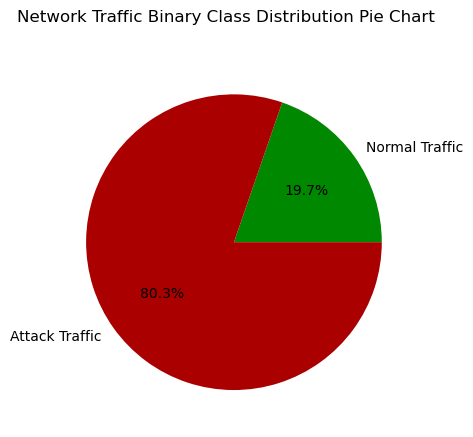

In [27]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = {1: "#AA0000", 0: '#008800'} 

show_pie_chart_target_variable(eda_df, labels, colors, 'Network Traffic Binary Class Distribution Pie Chart')

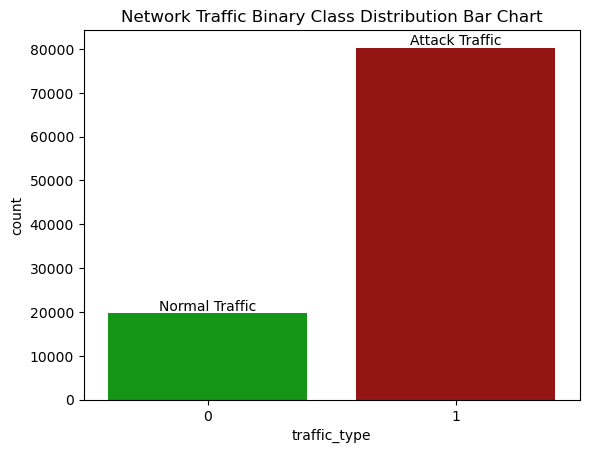

In [28]:
labels = ['Normal Traffic', 'Attack Traffic']
colors = ['#00AA00',"#AA0000"]

show_bar_chart_target_variable(eda_df, target_variable, labels, colors, 'Network Traffic Binary Class Distribution Bar Chart')

In [29]:
eda_features_df = eda_df.drop([target_variable], axis=1)

In [30]:
categorical_attributes, continuous_attributes = split_dataframe_into_continuious_categorical_column_names(eda_features_df)




Summary for PROTOCOL_TYPE feature value counts

icmp    58259
tcp     37765
udp      3976
Name: protocol_type, dtype: int64



Summary for FLAG feature value counts

SF        76673
S0        17584
REJ        5426
RSTR        166
RSTO        111
SH           20
S1           15
RSTOS0        4
S3            1
Name: flag, dtype: int64



Summary for SERVICE feature value counts

ecr_i          57796
private        22189
http           12538
smtp            1975
other           1524
domain_u        1164
ftp_data         818
eco_i            339
finger           162
urp_i            121
ftp              110
ntp_u             81
telnet            80
auth              73
pop_3             39
uucp_path         34
time              31
name              29
iso_tsap          28
systat            28
rje               28
netbios_dgm       27
discard           27
sunrpc            26
imap4             26
netstat           25
whois             25
mtp               25
ssh               25
login   

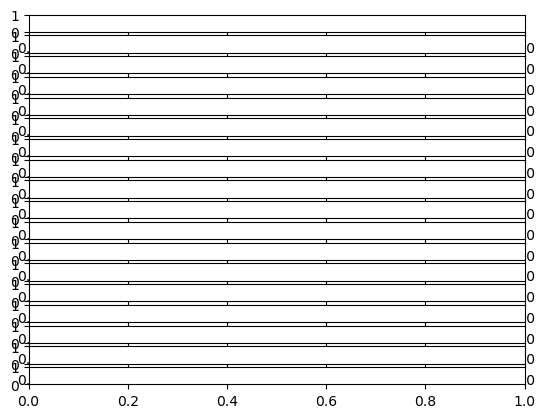

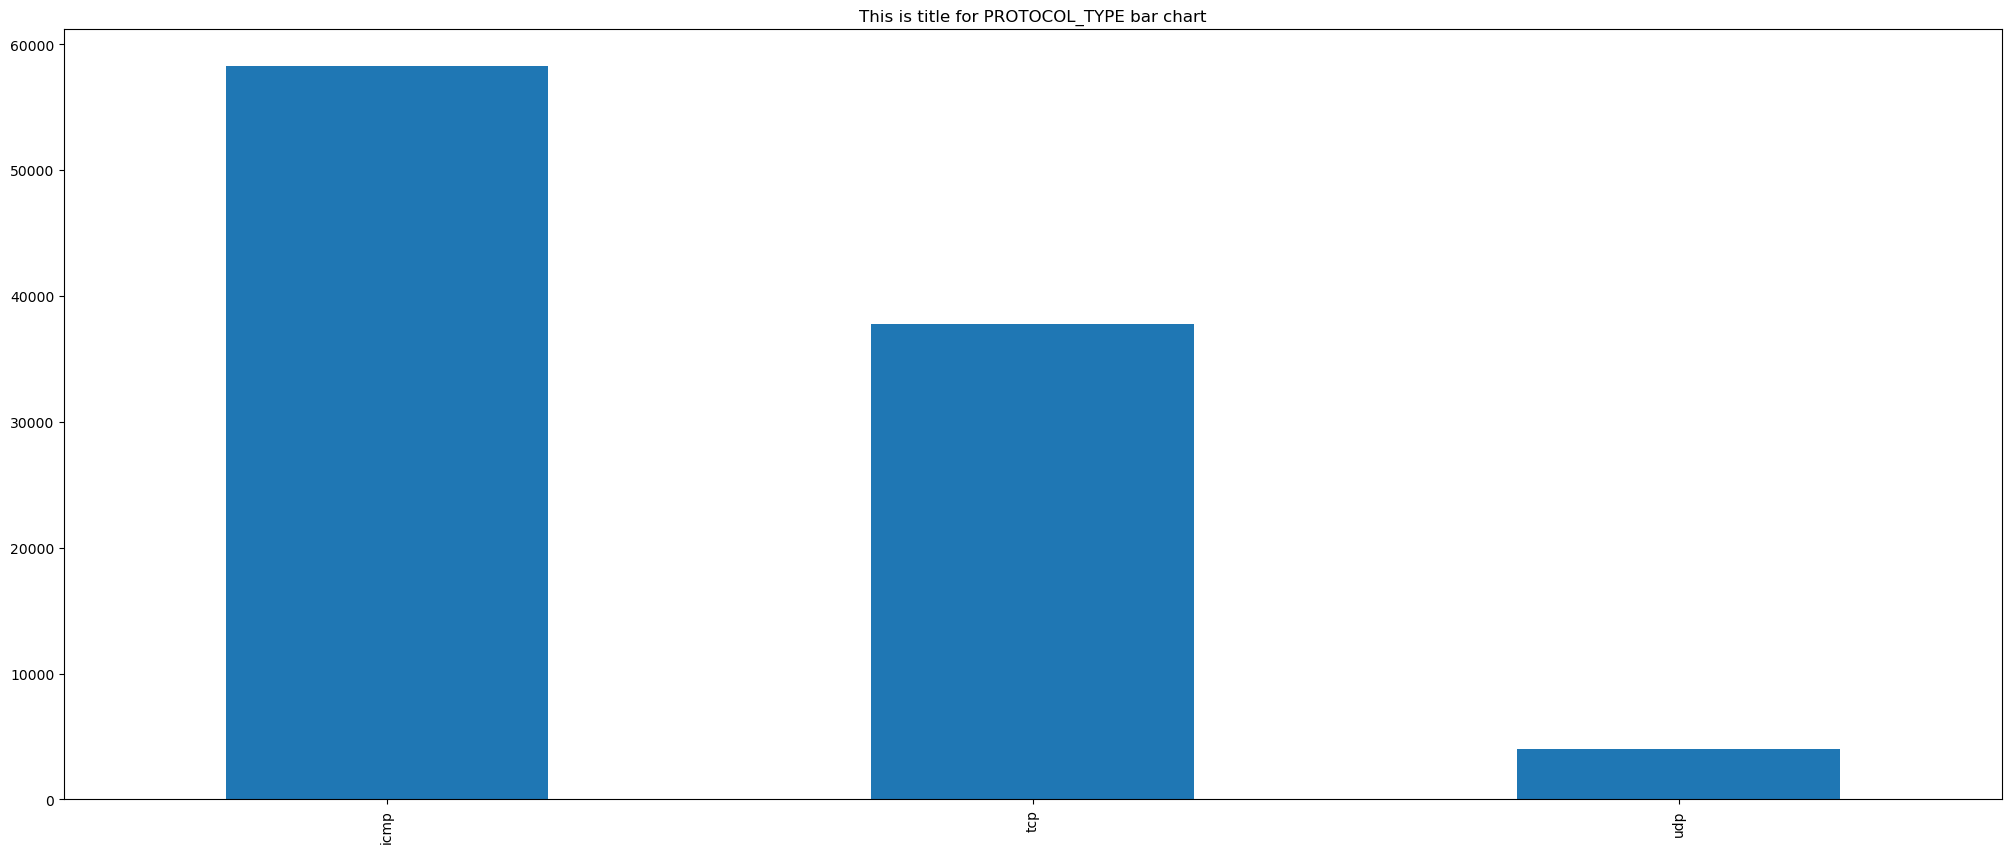

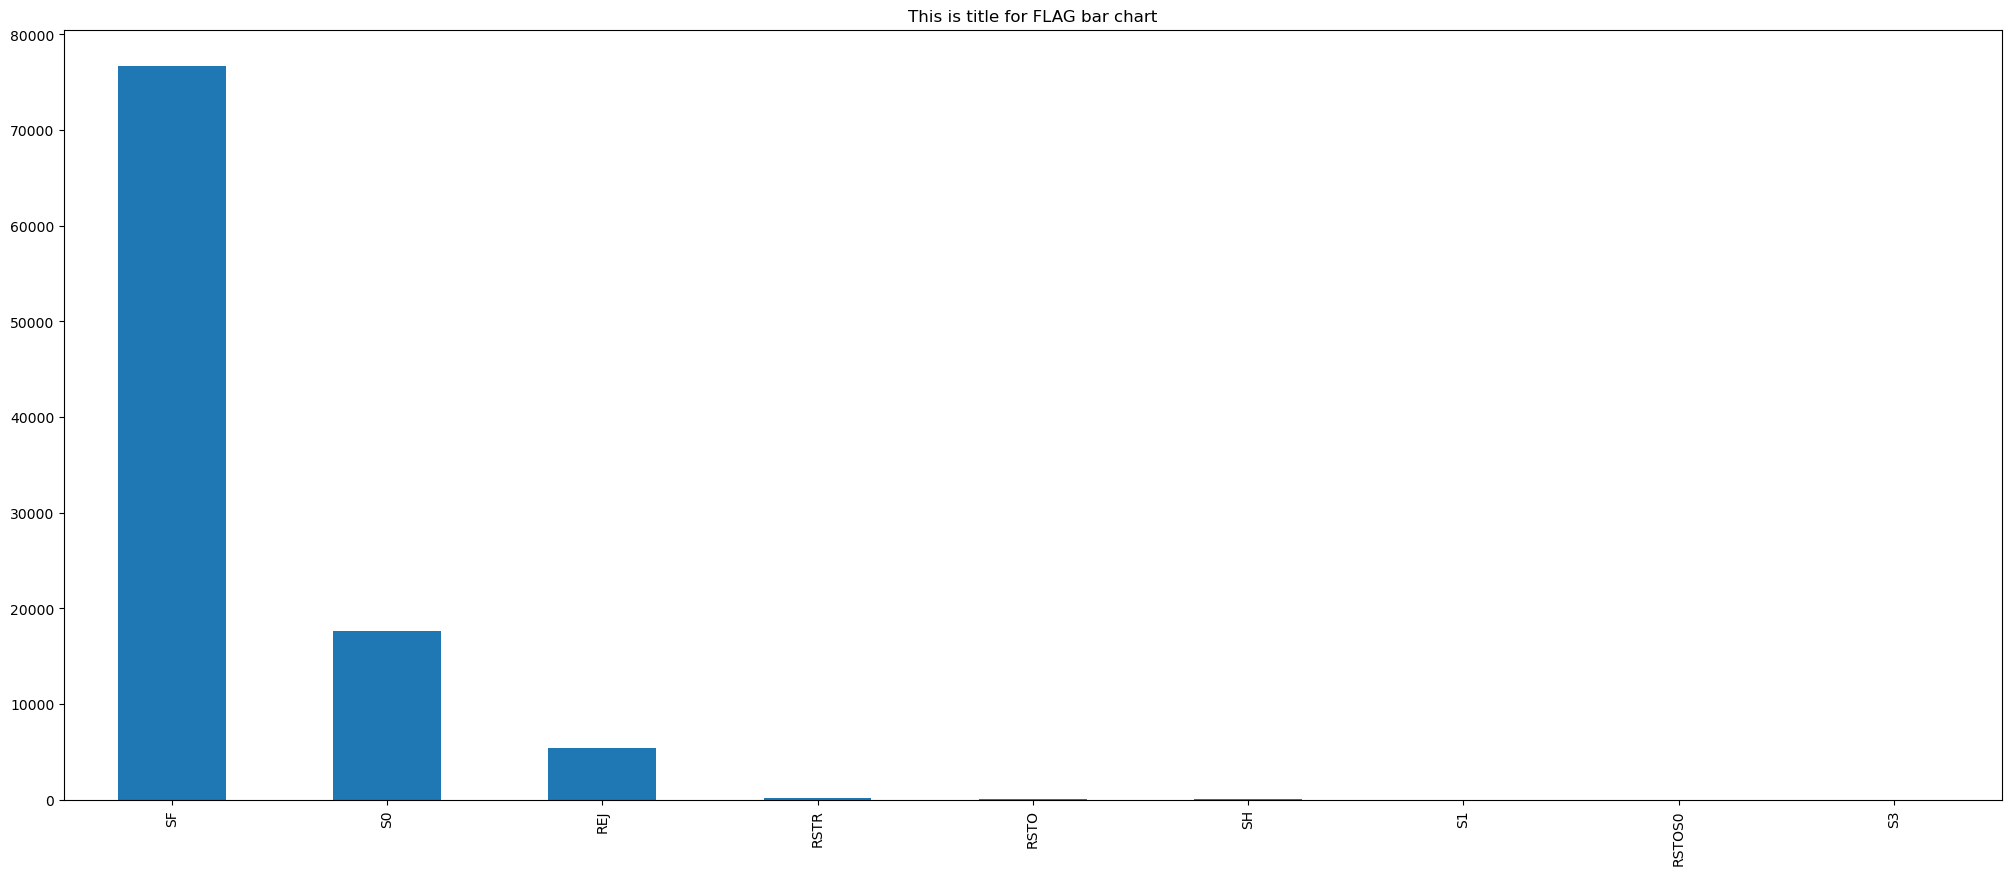

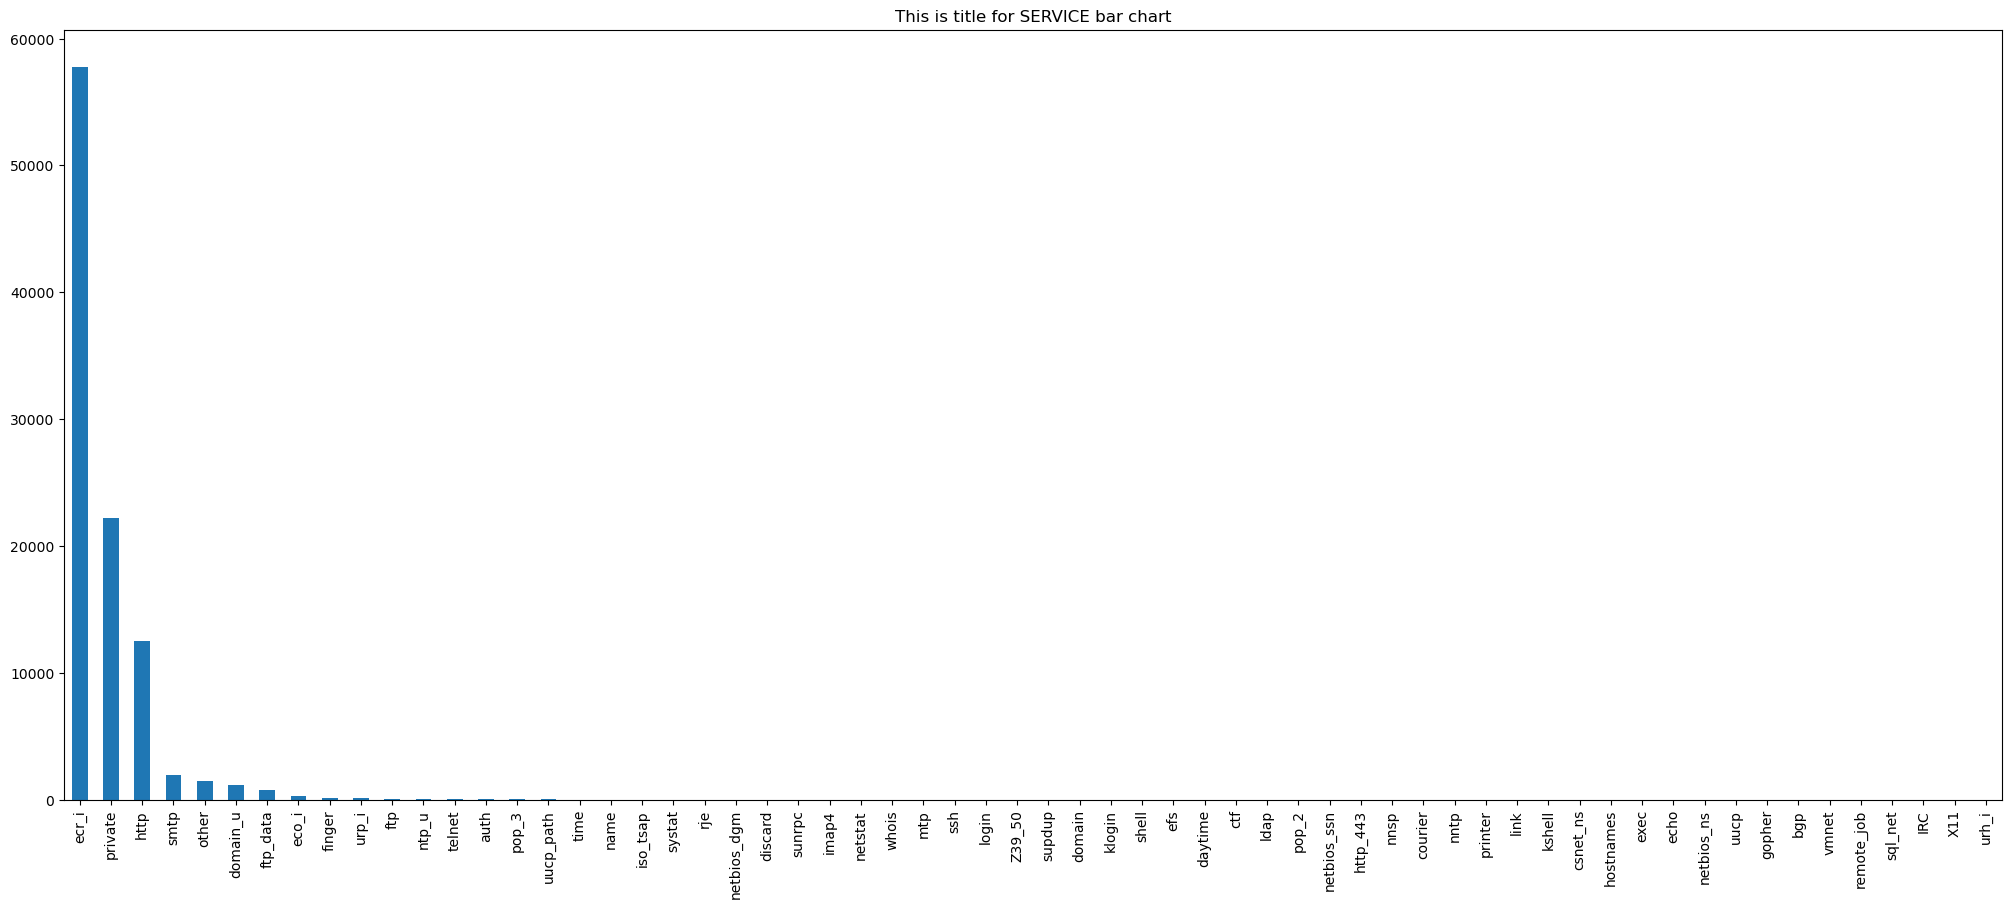

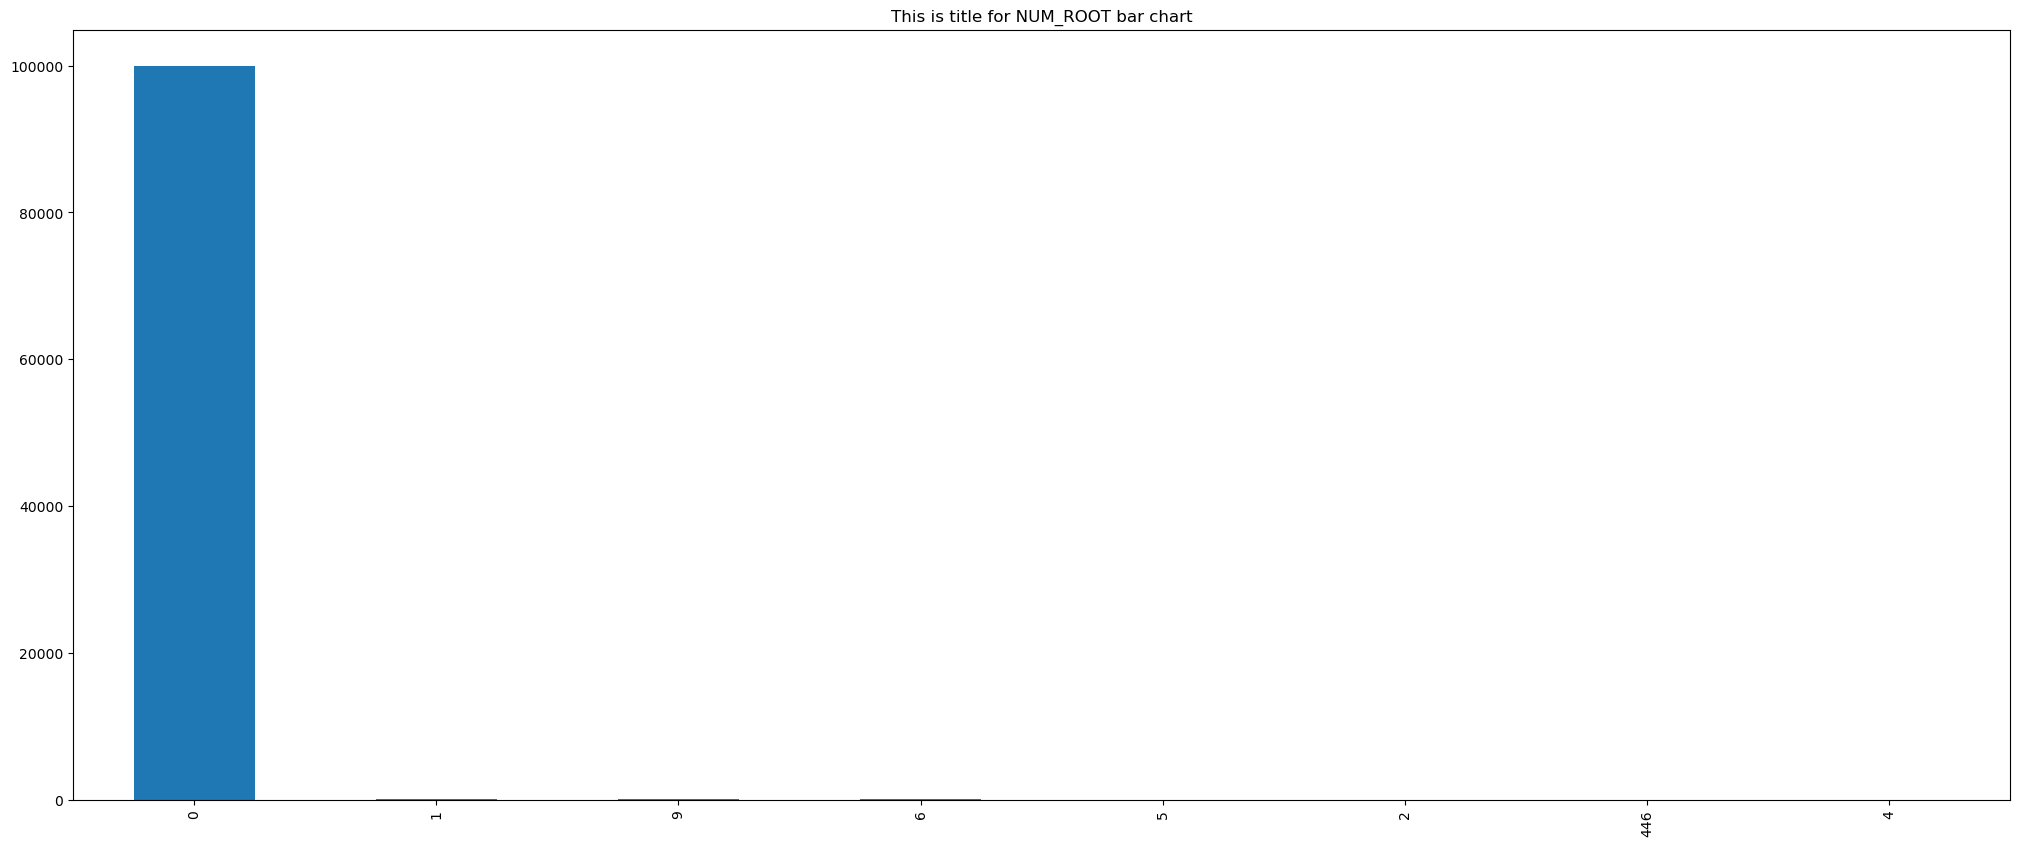

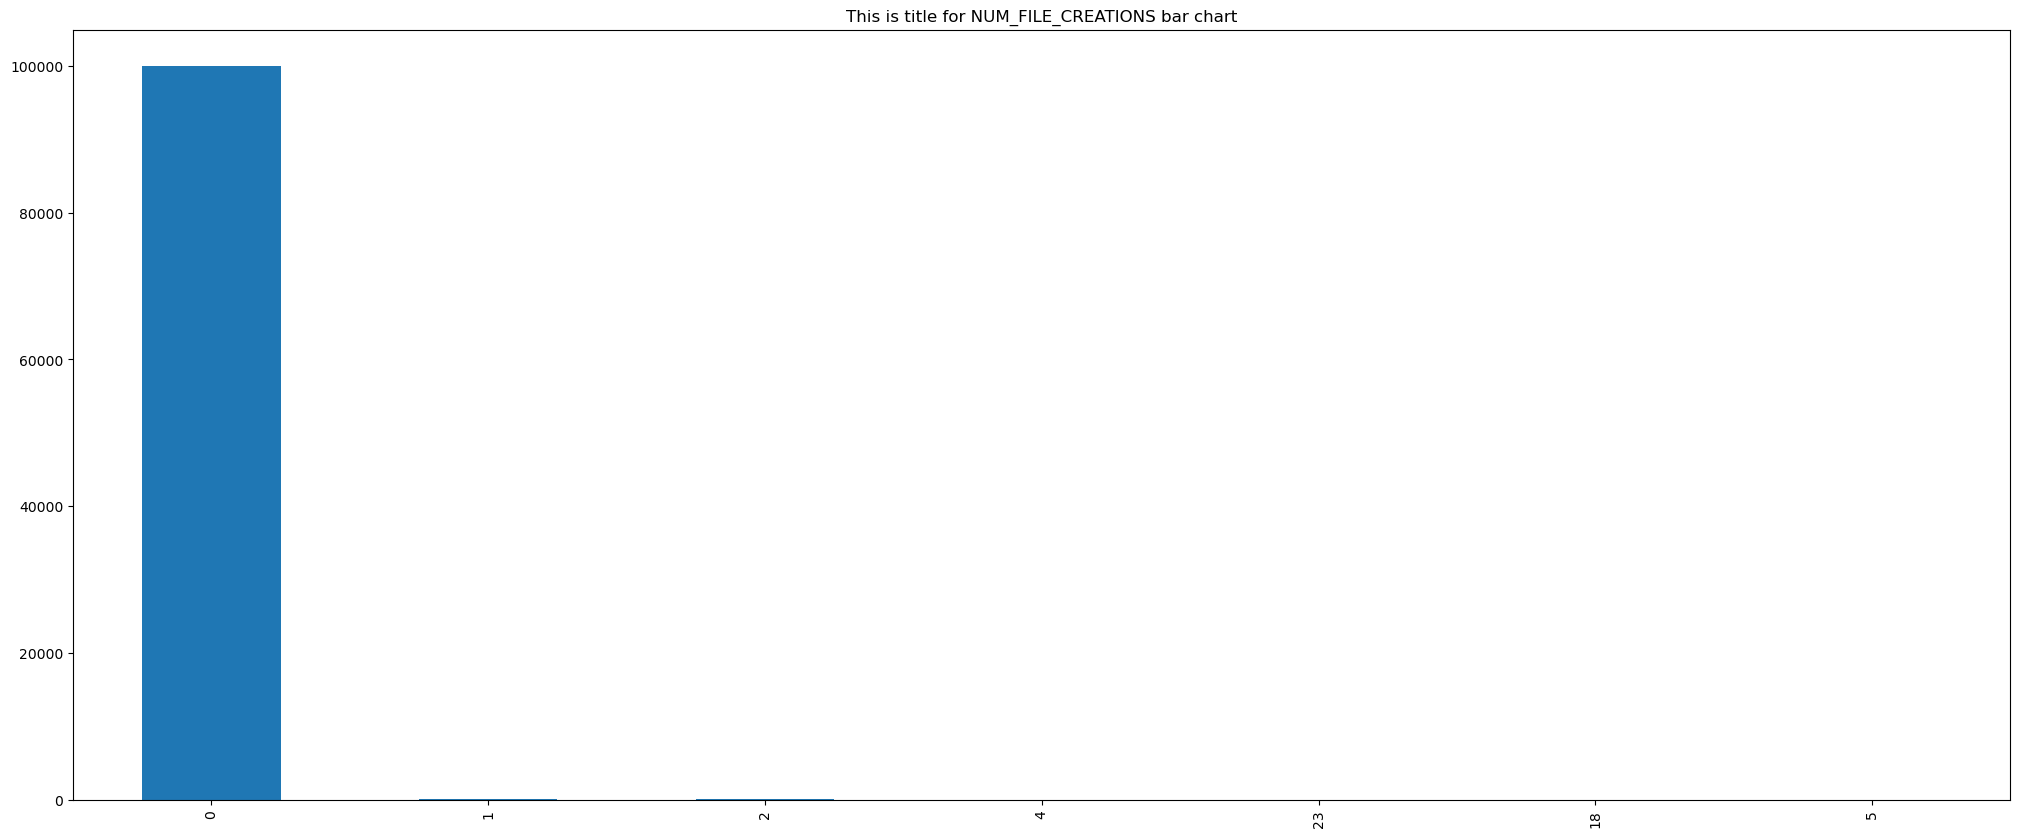

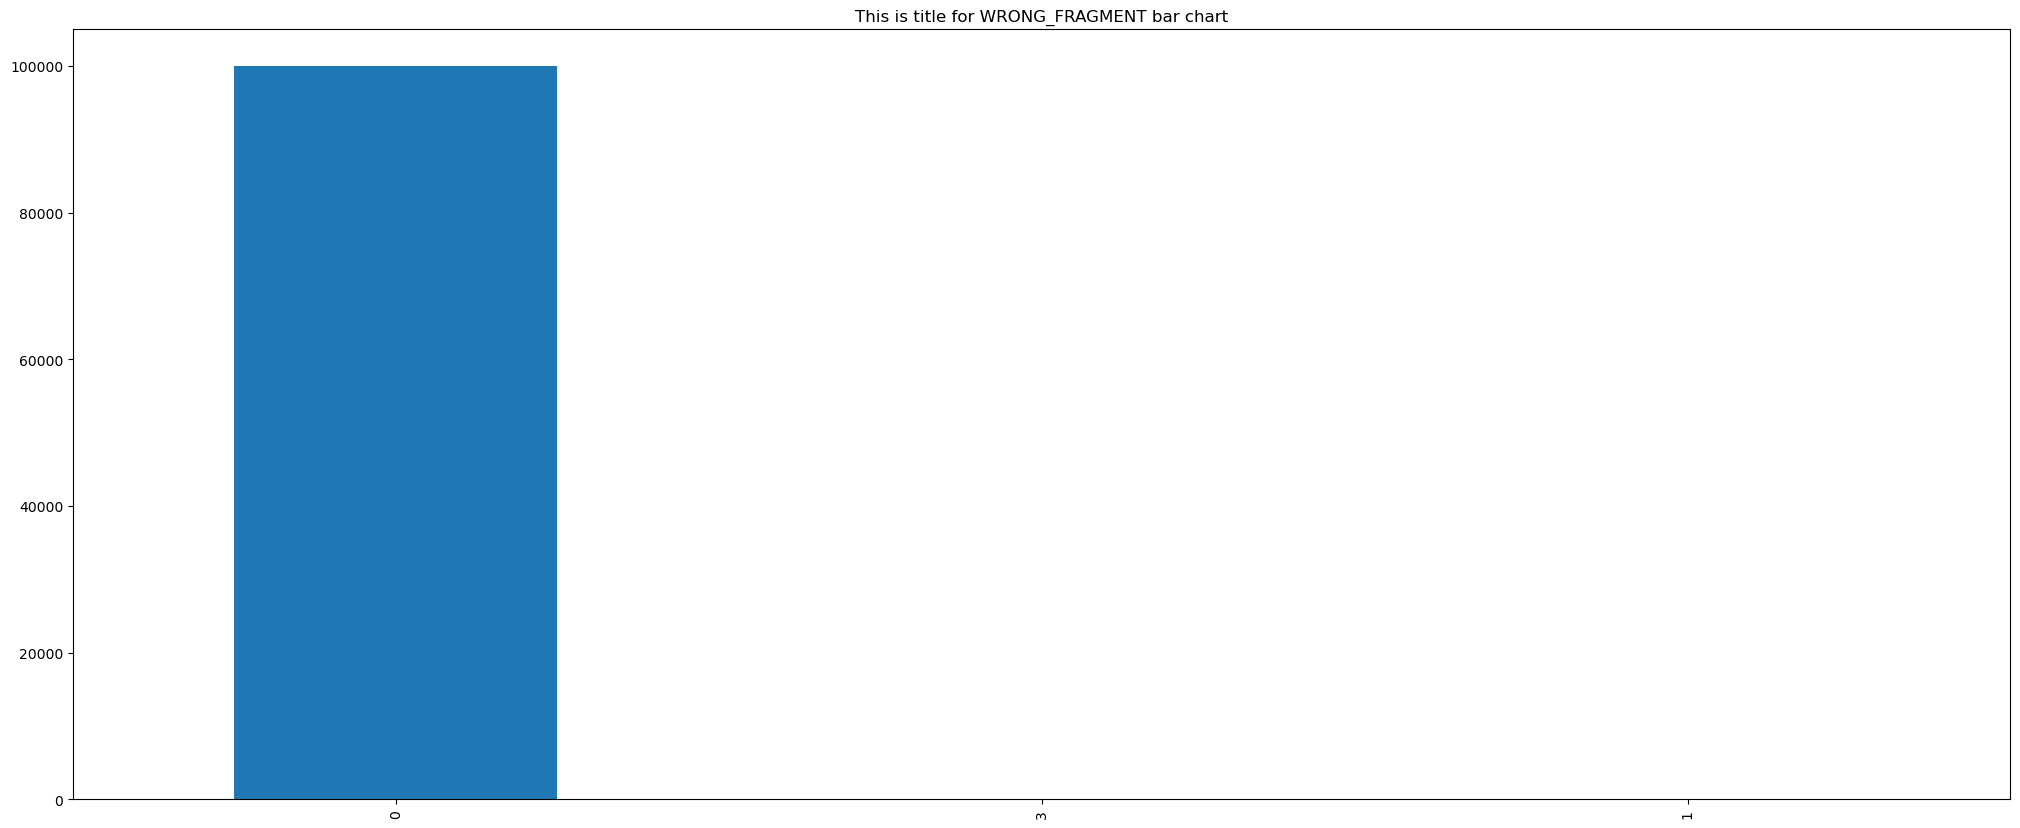

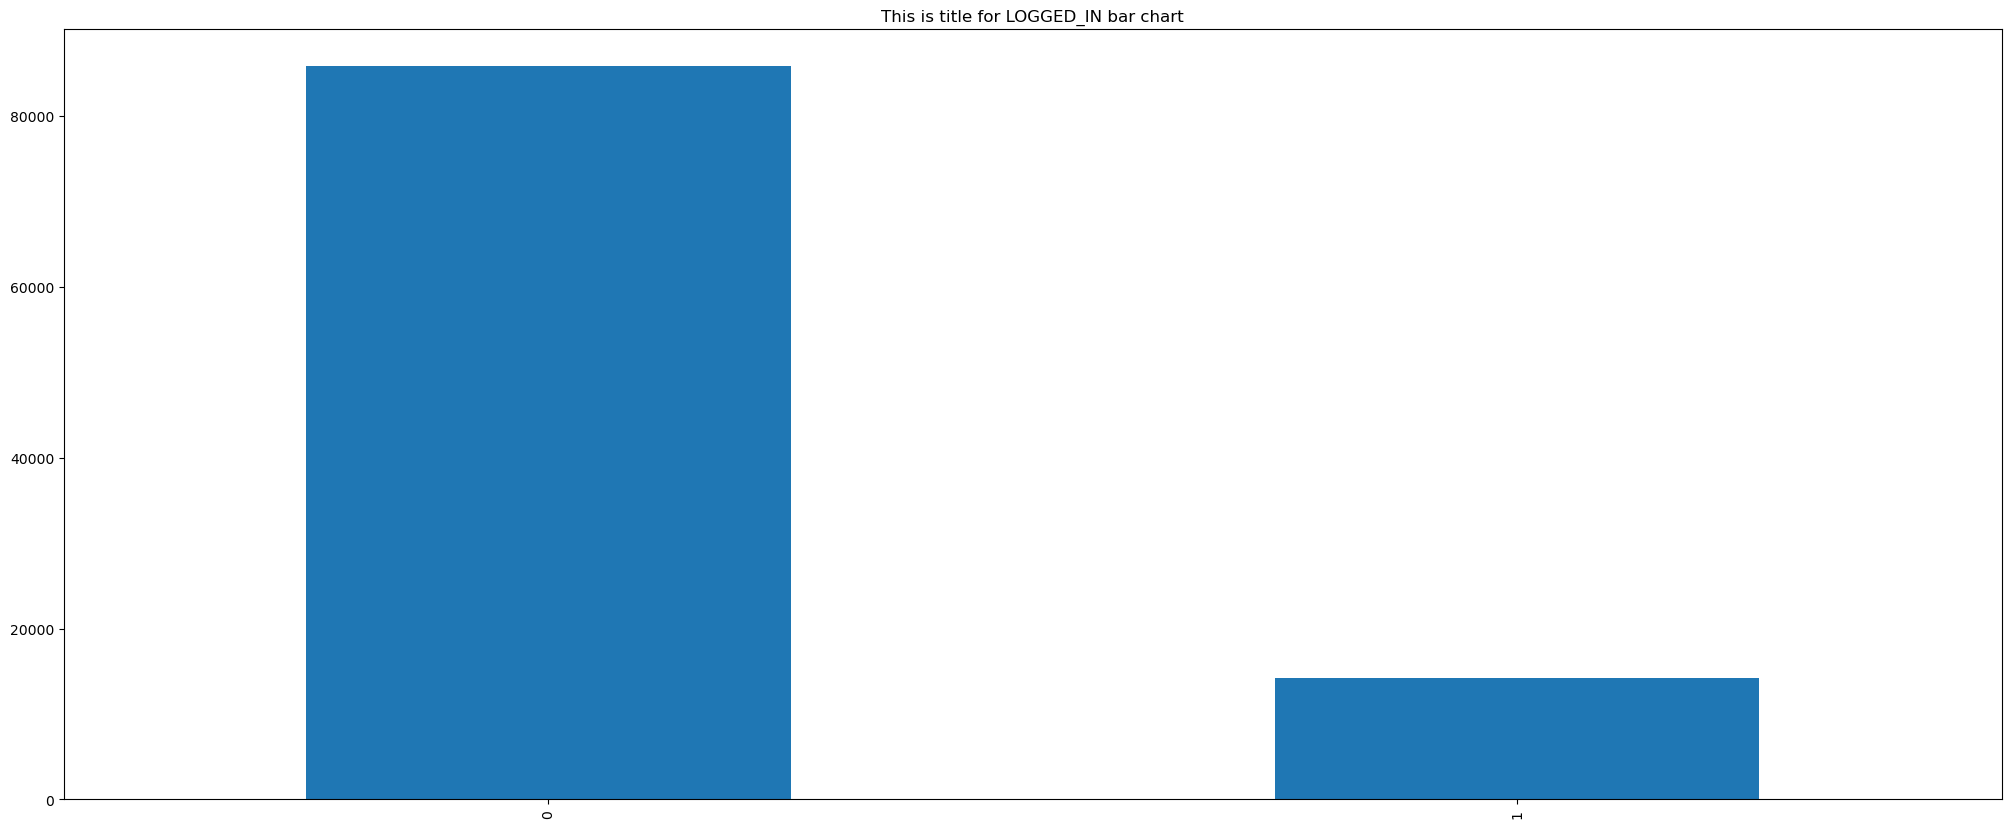

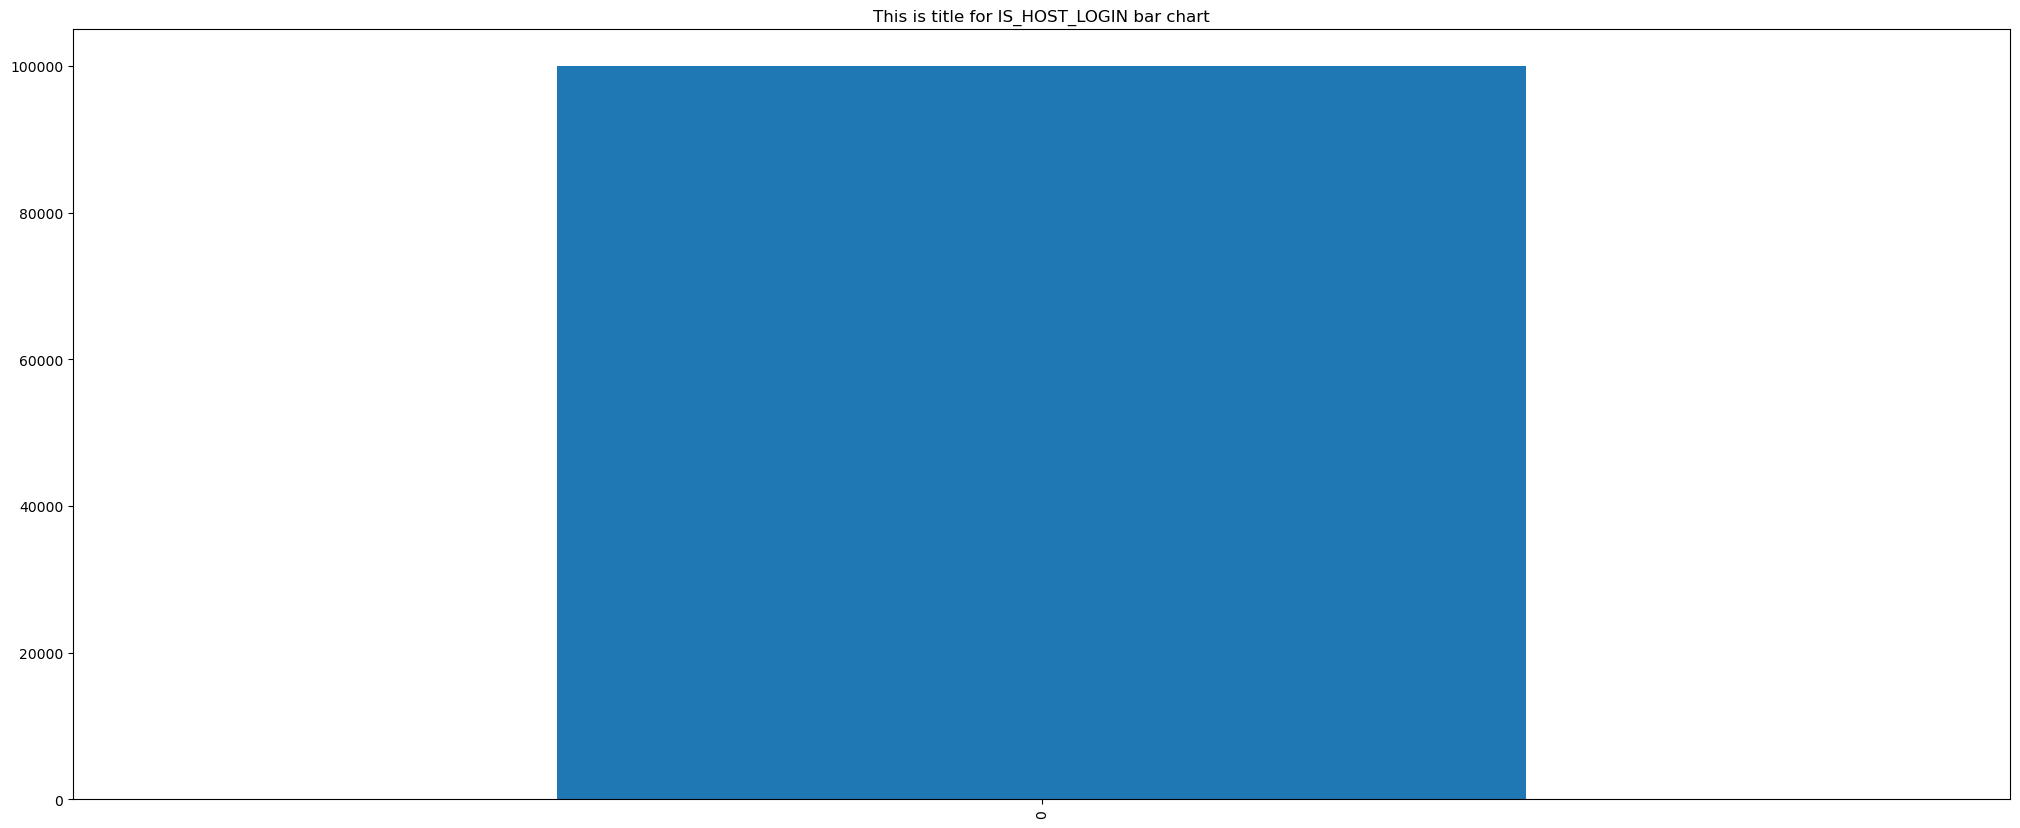

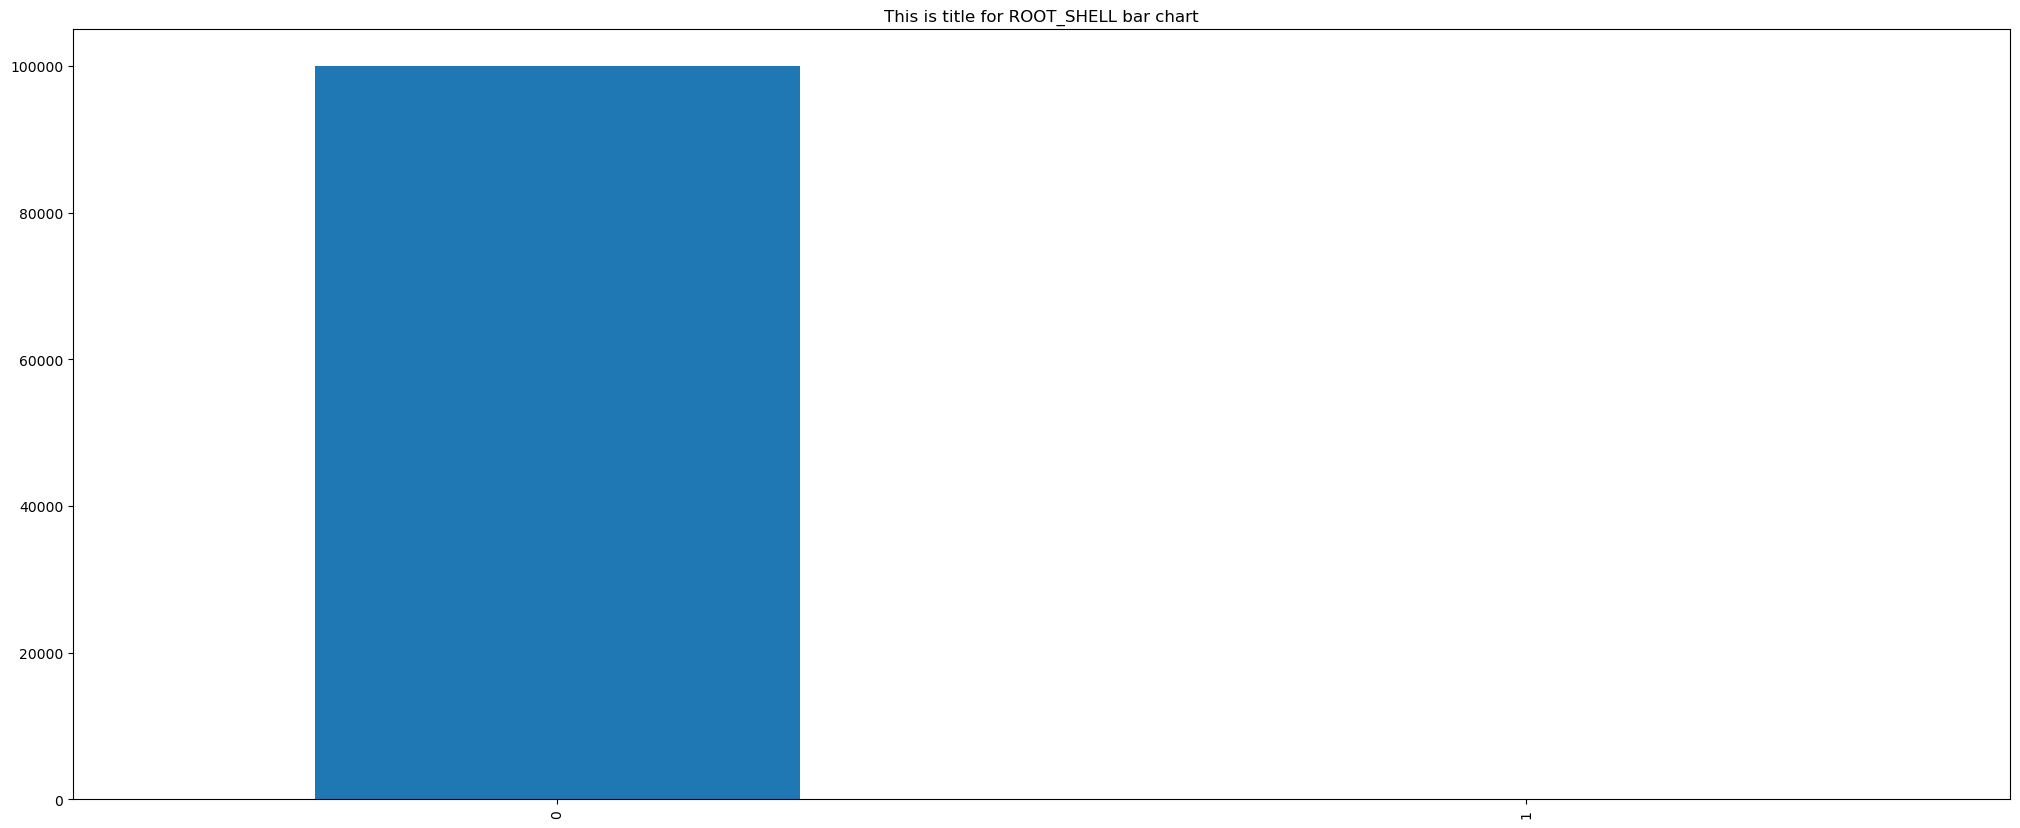

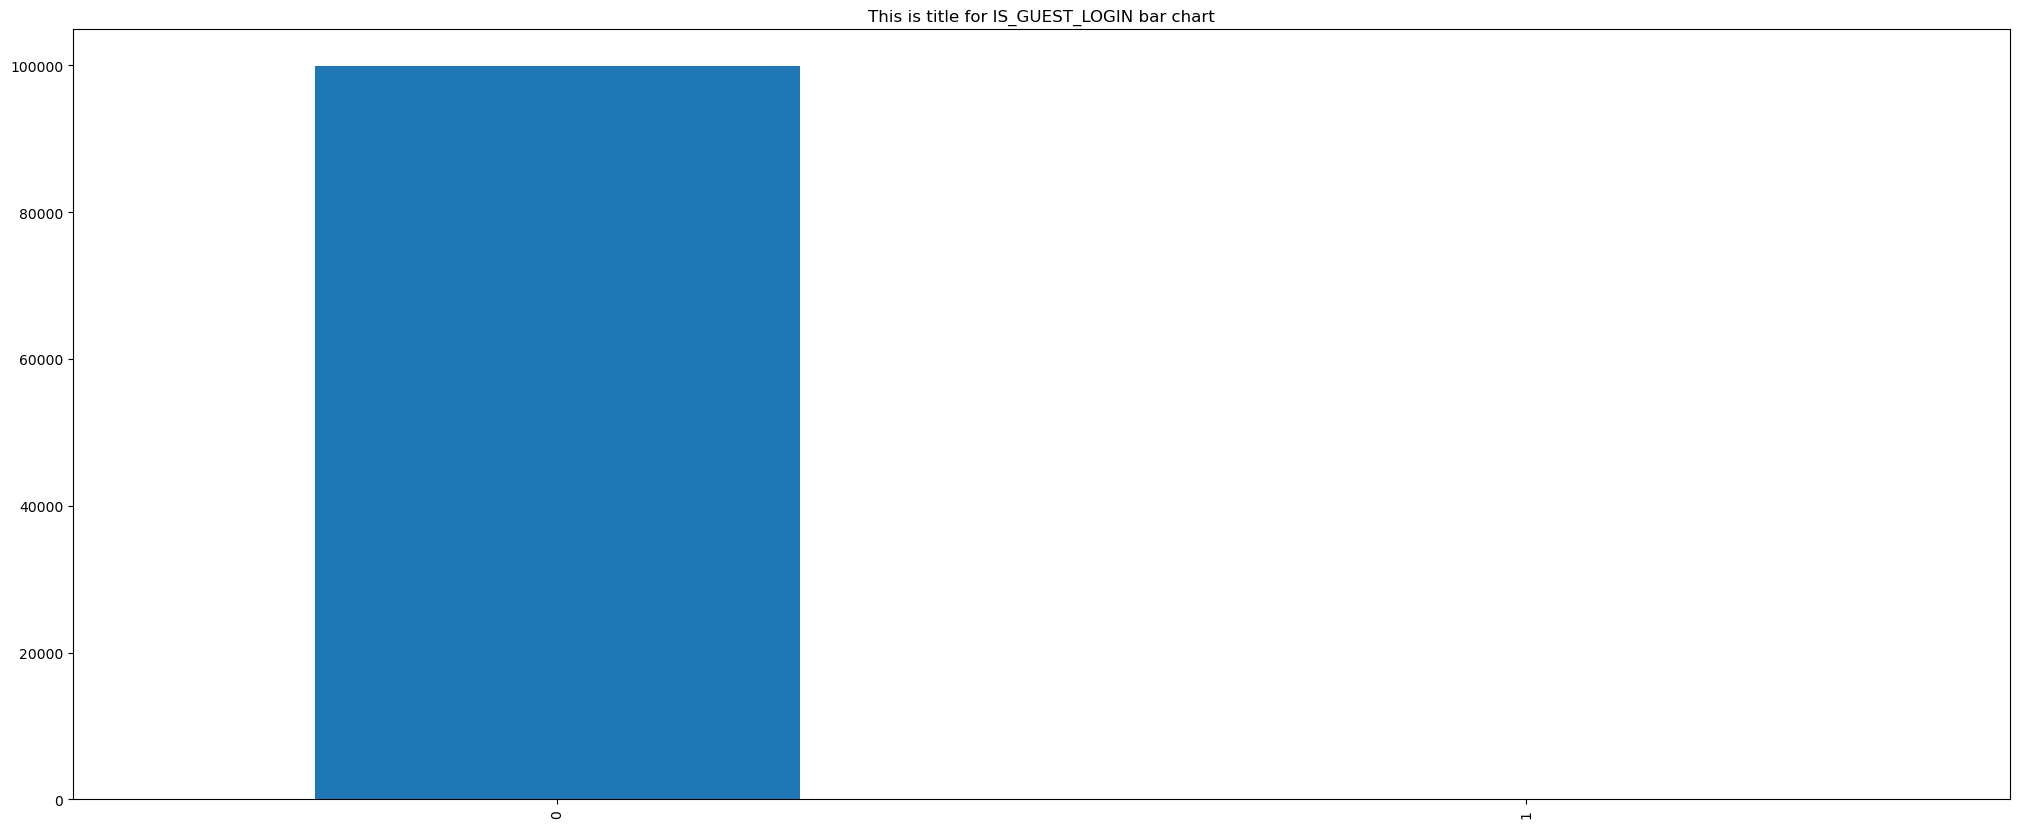

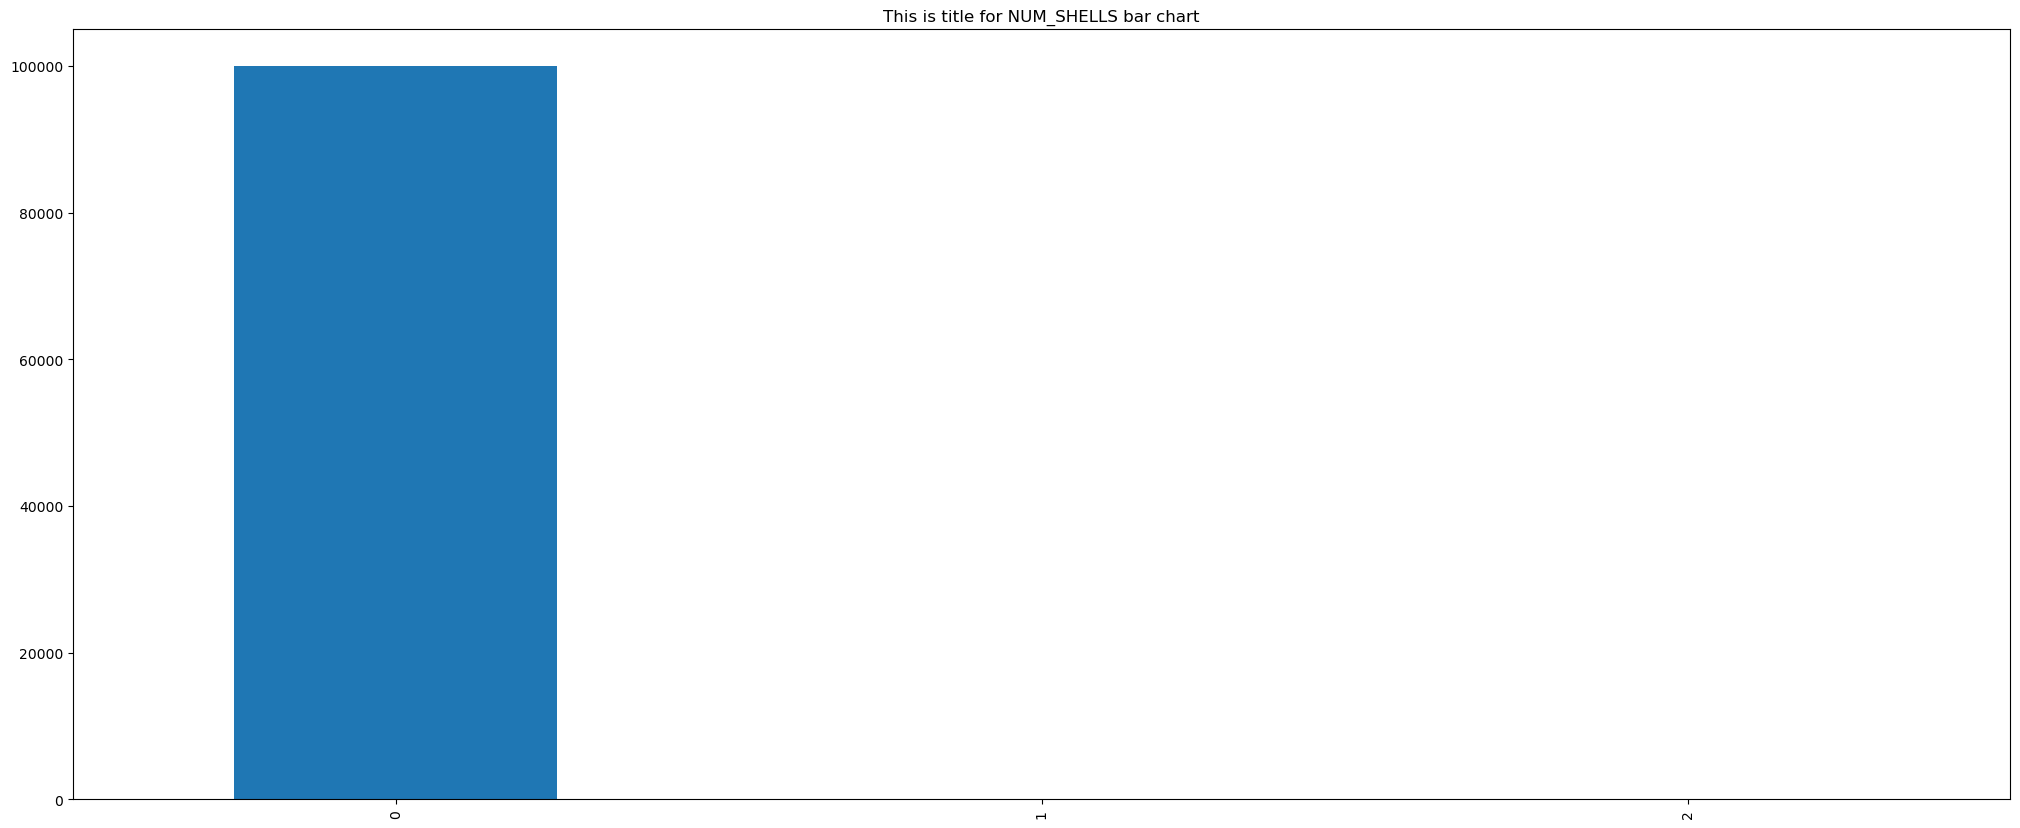

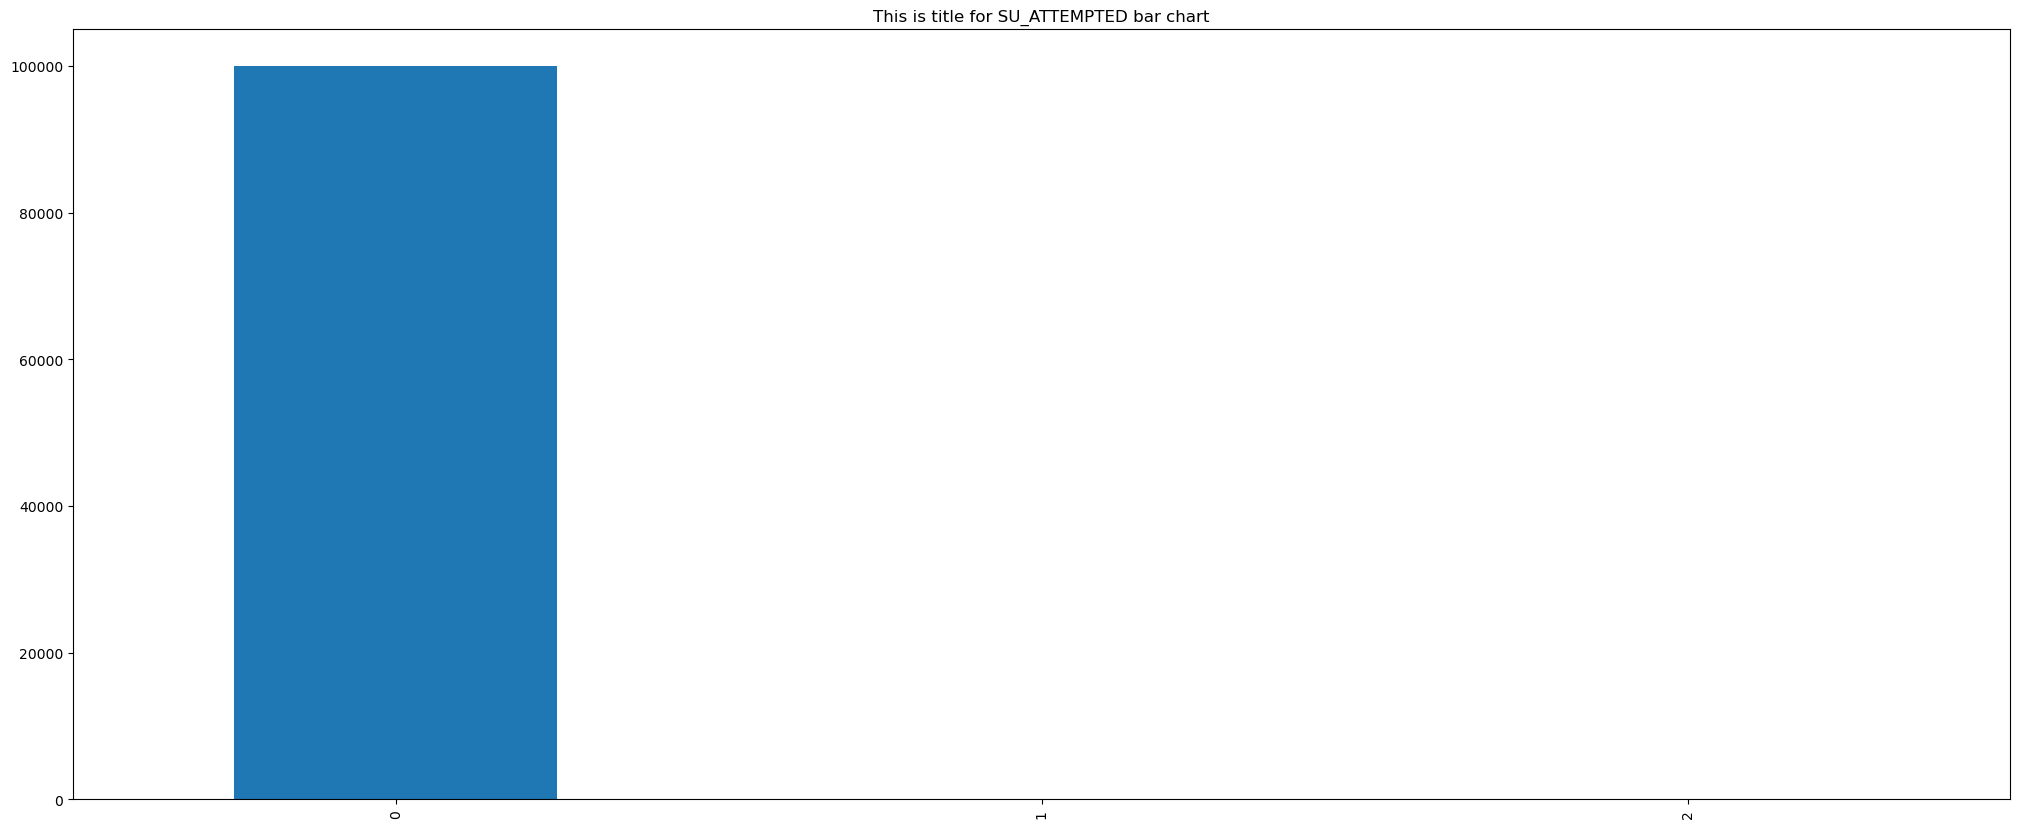

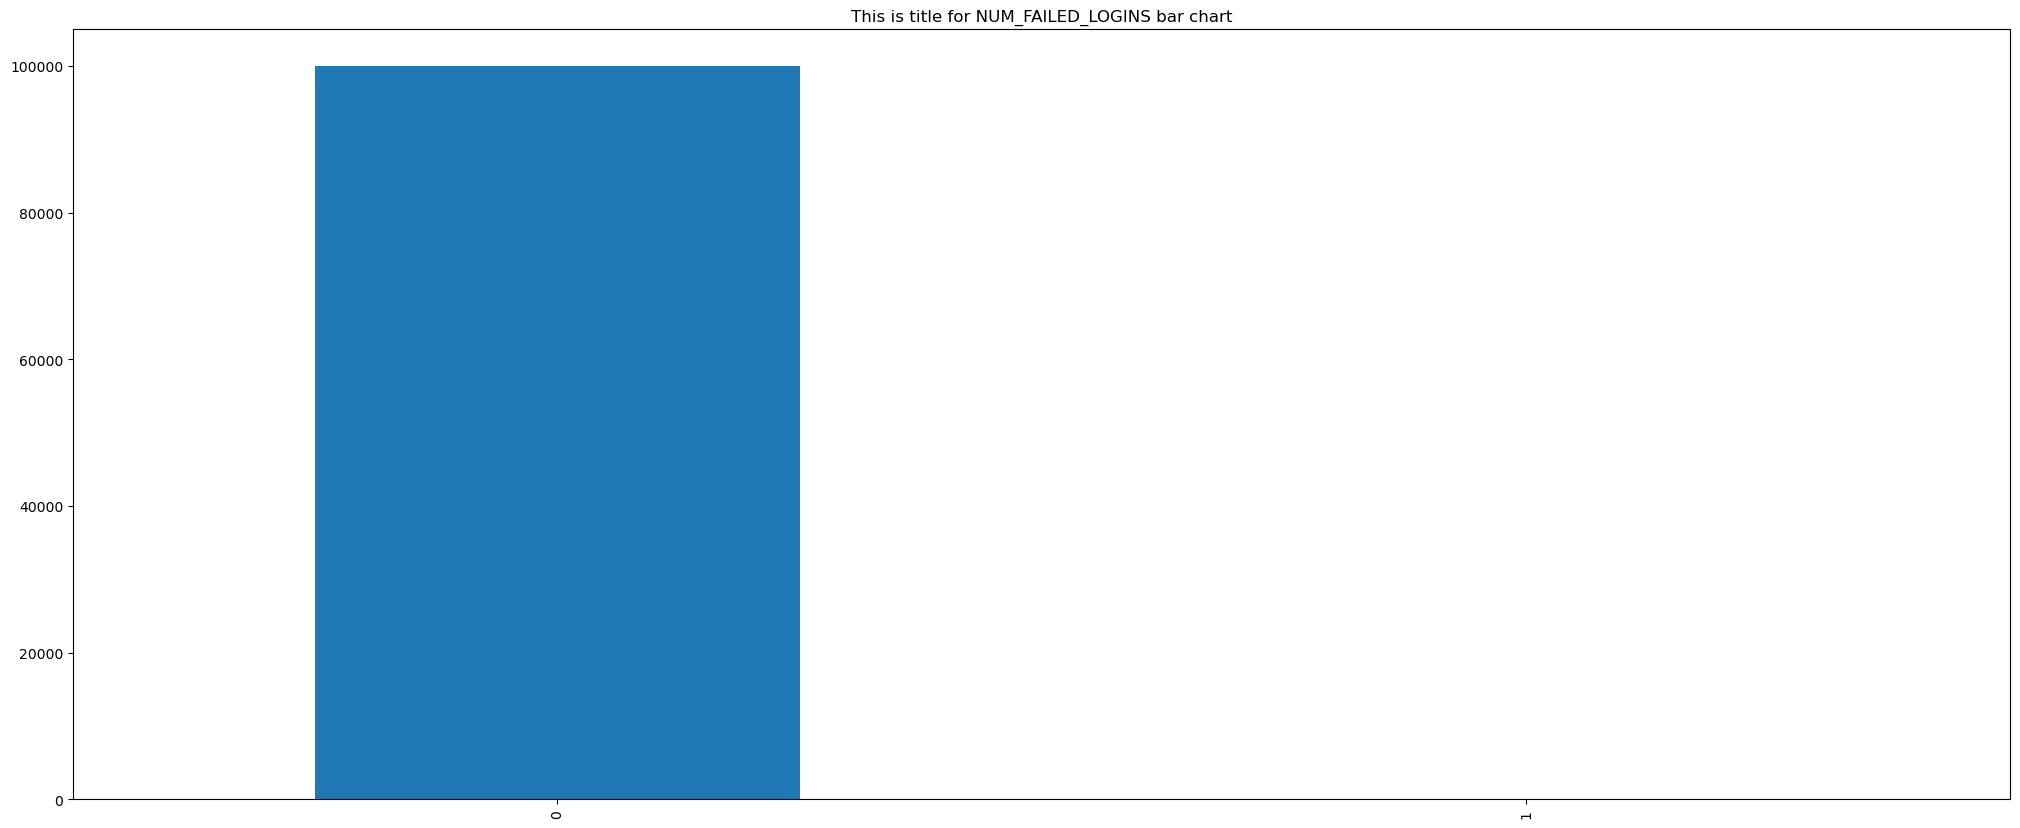

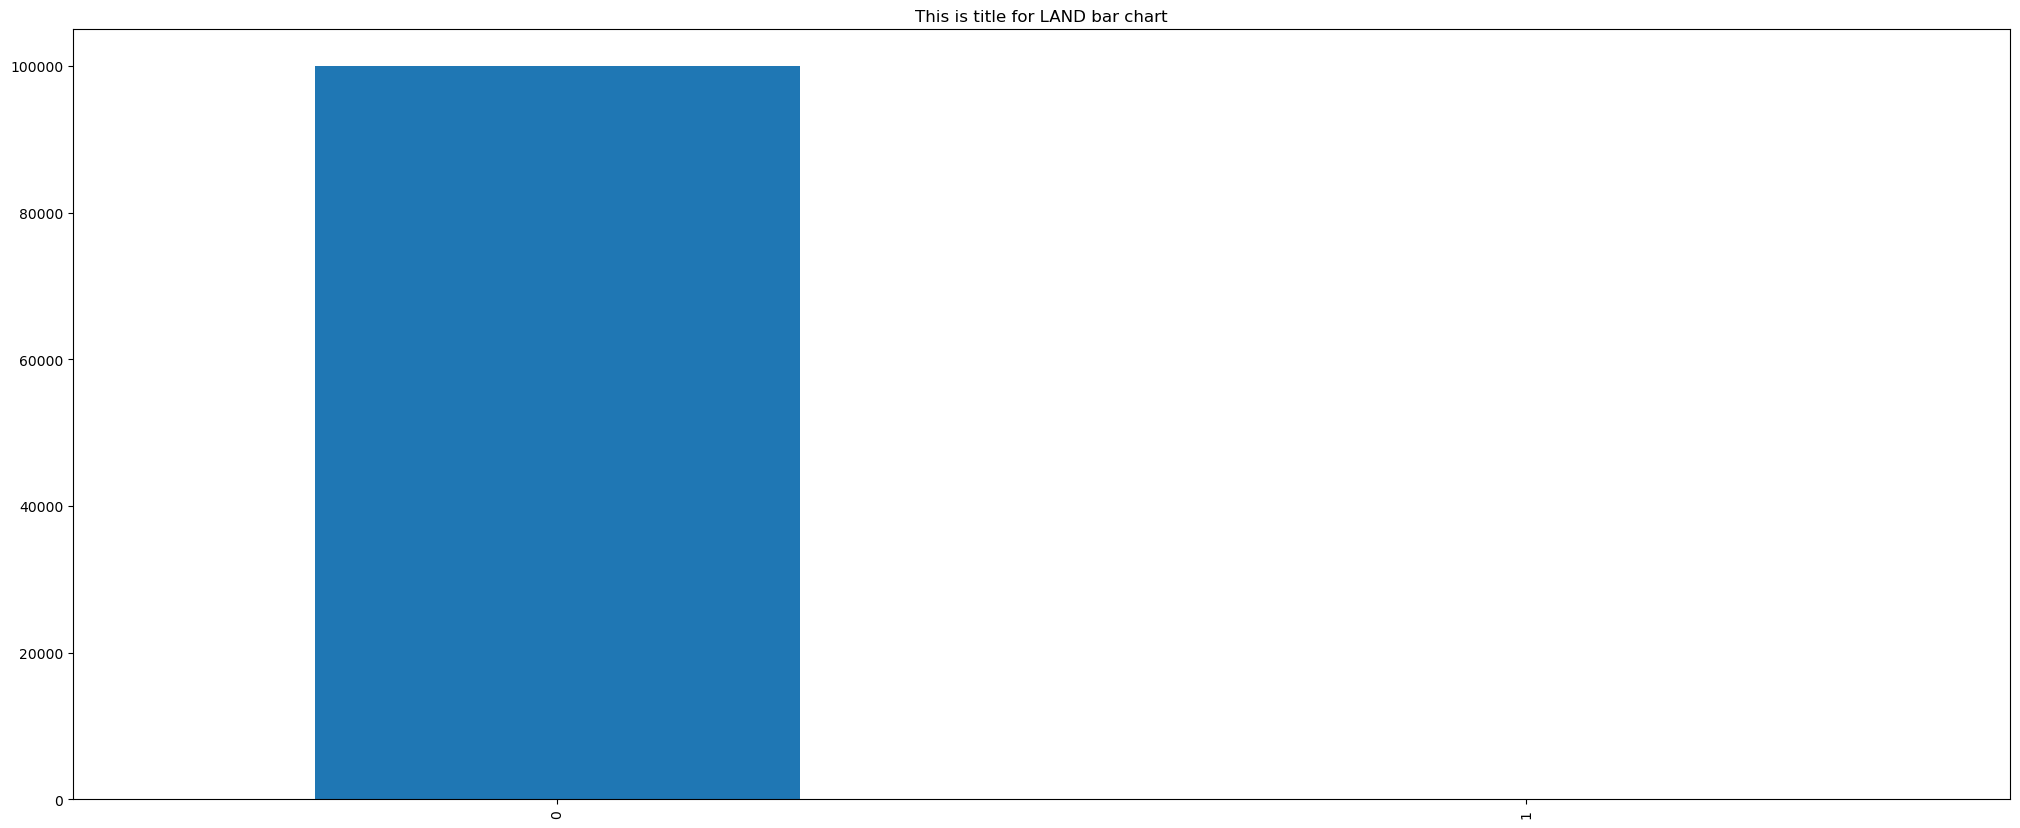

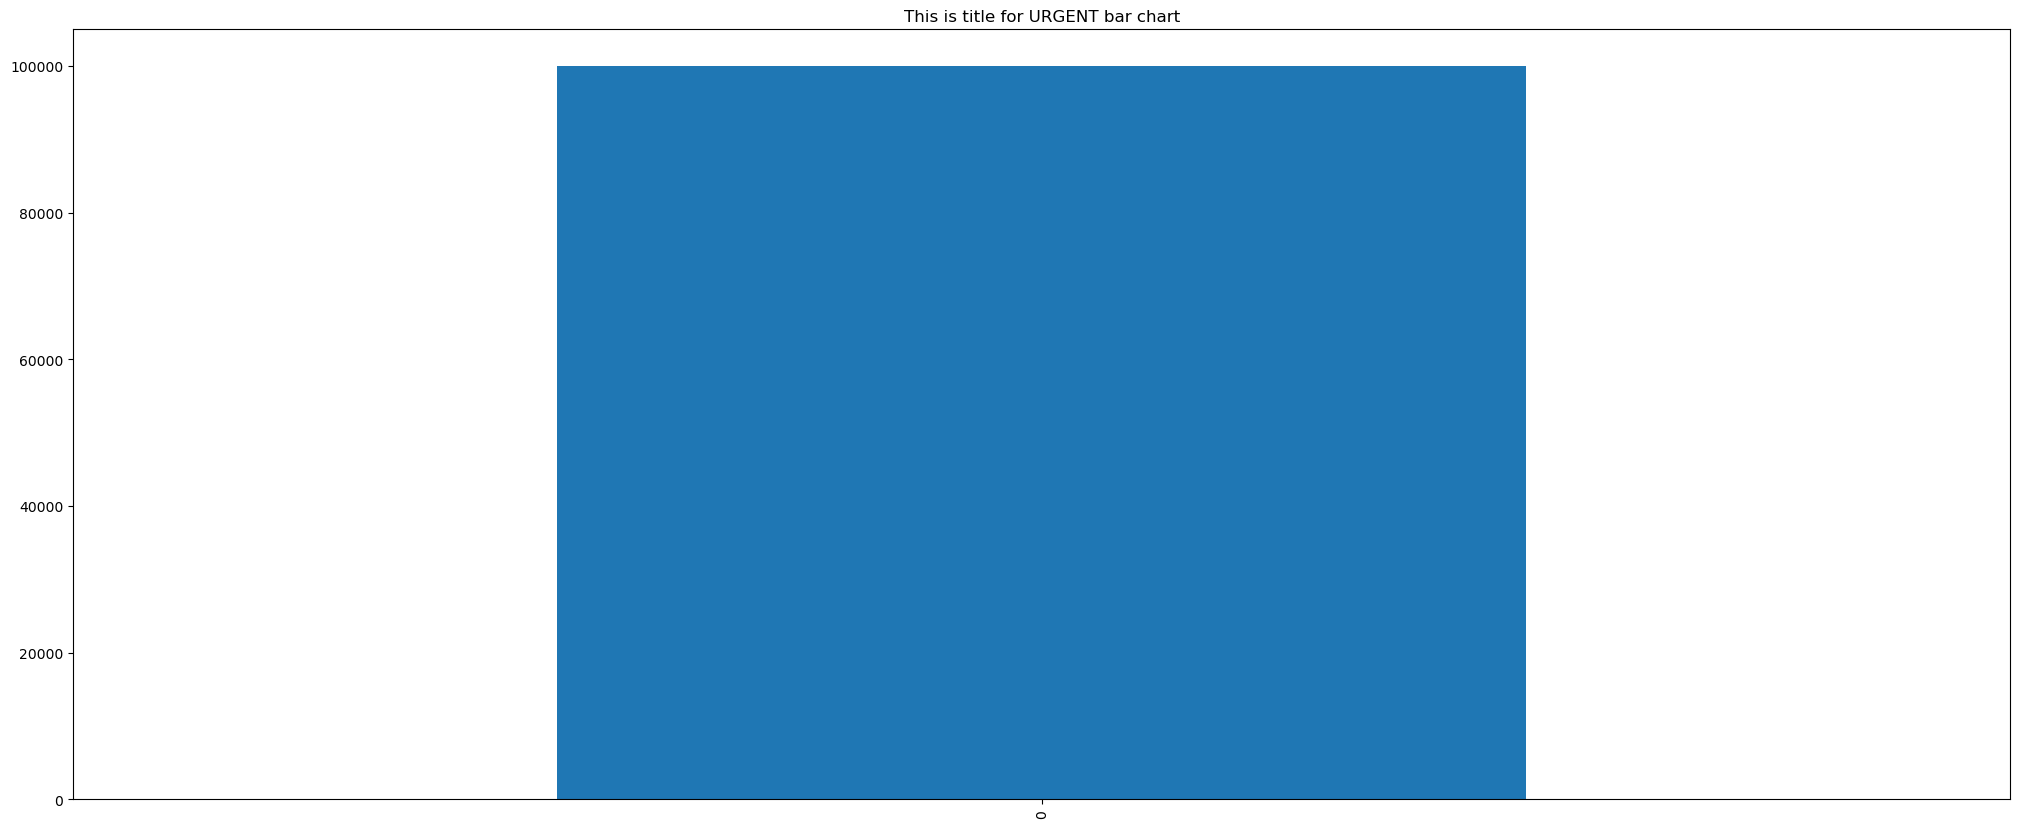

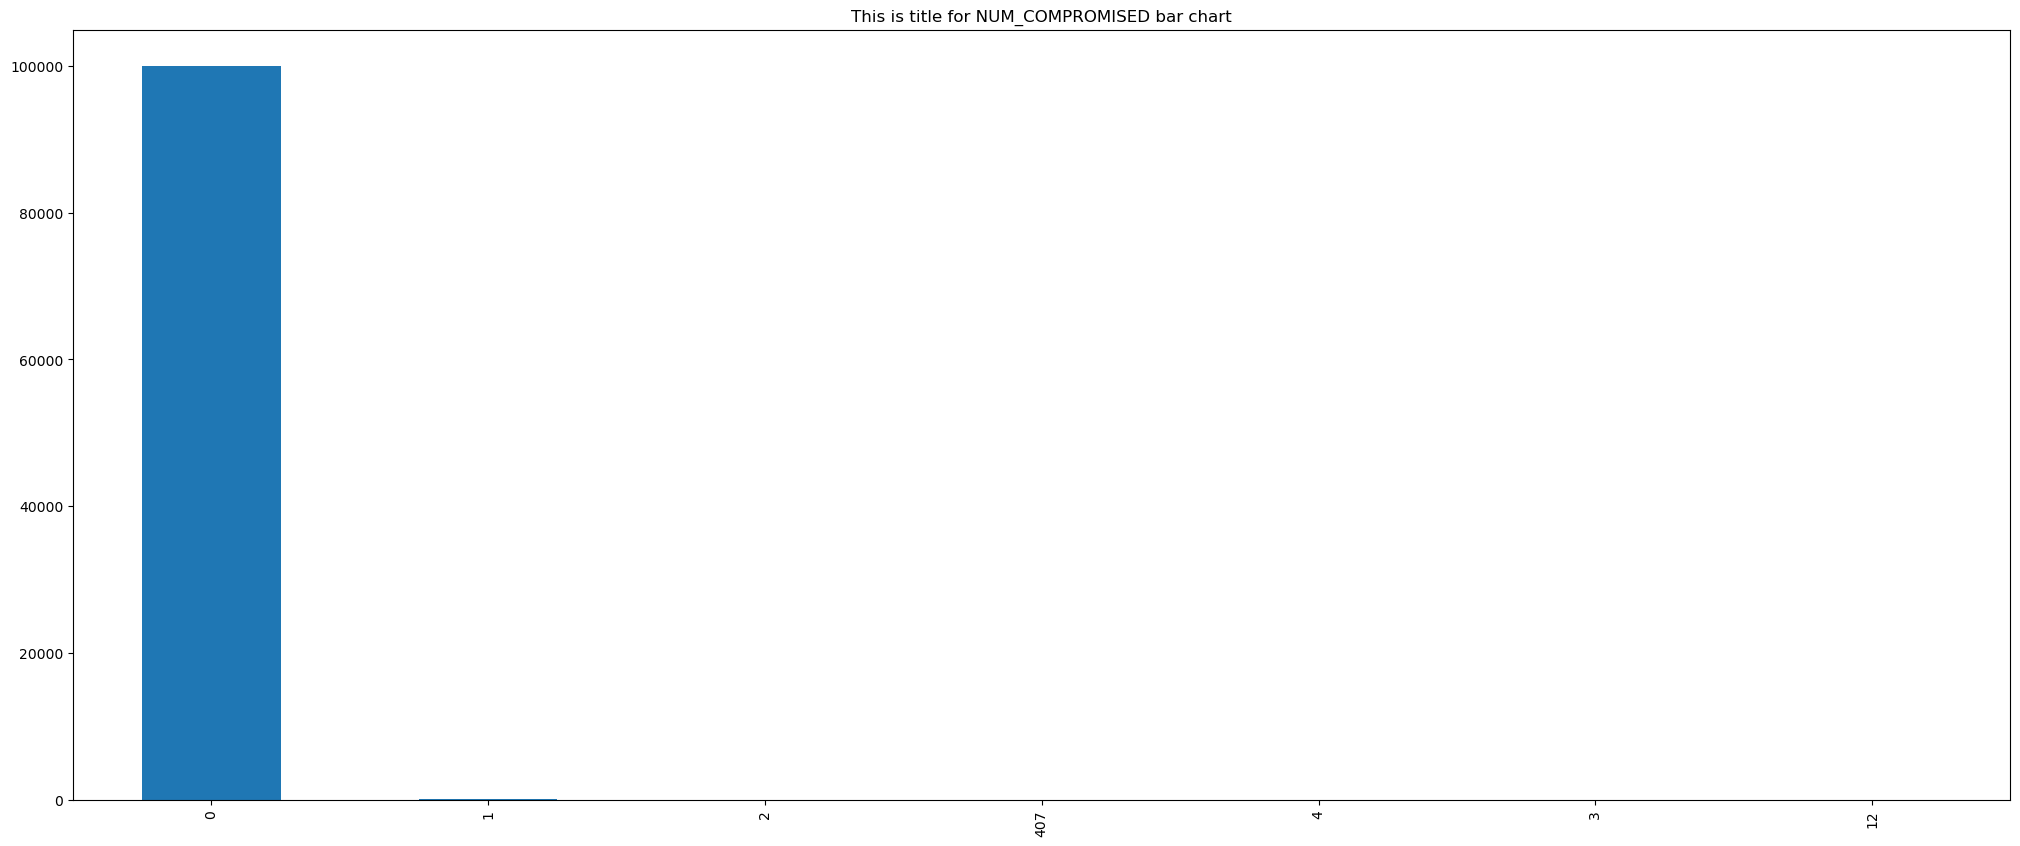

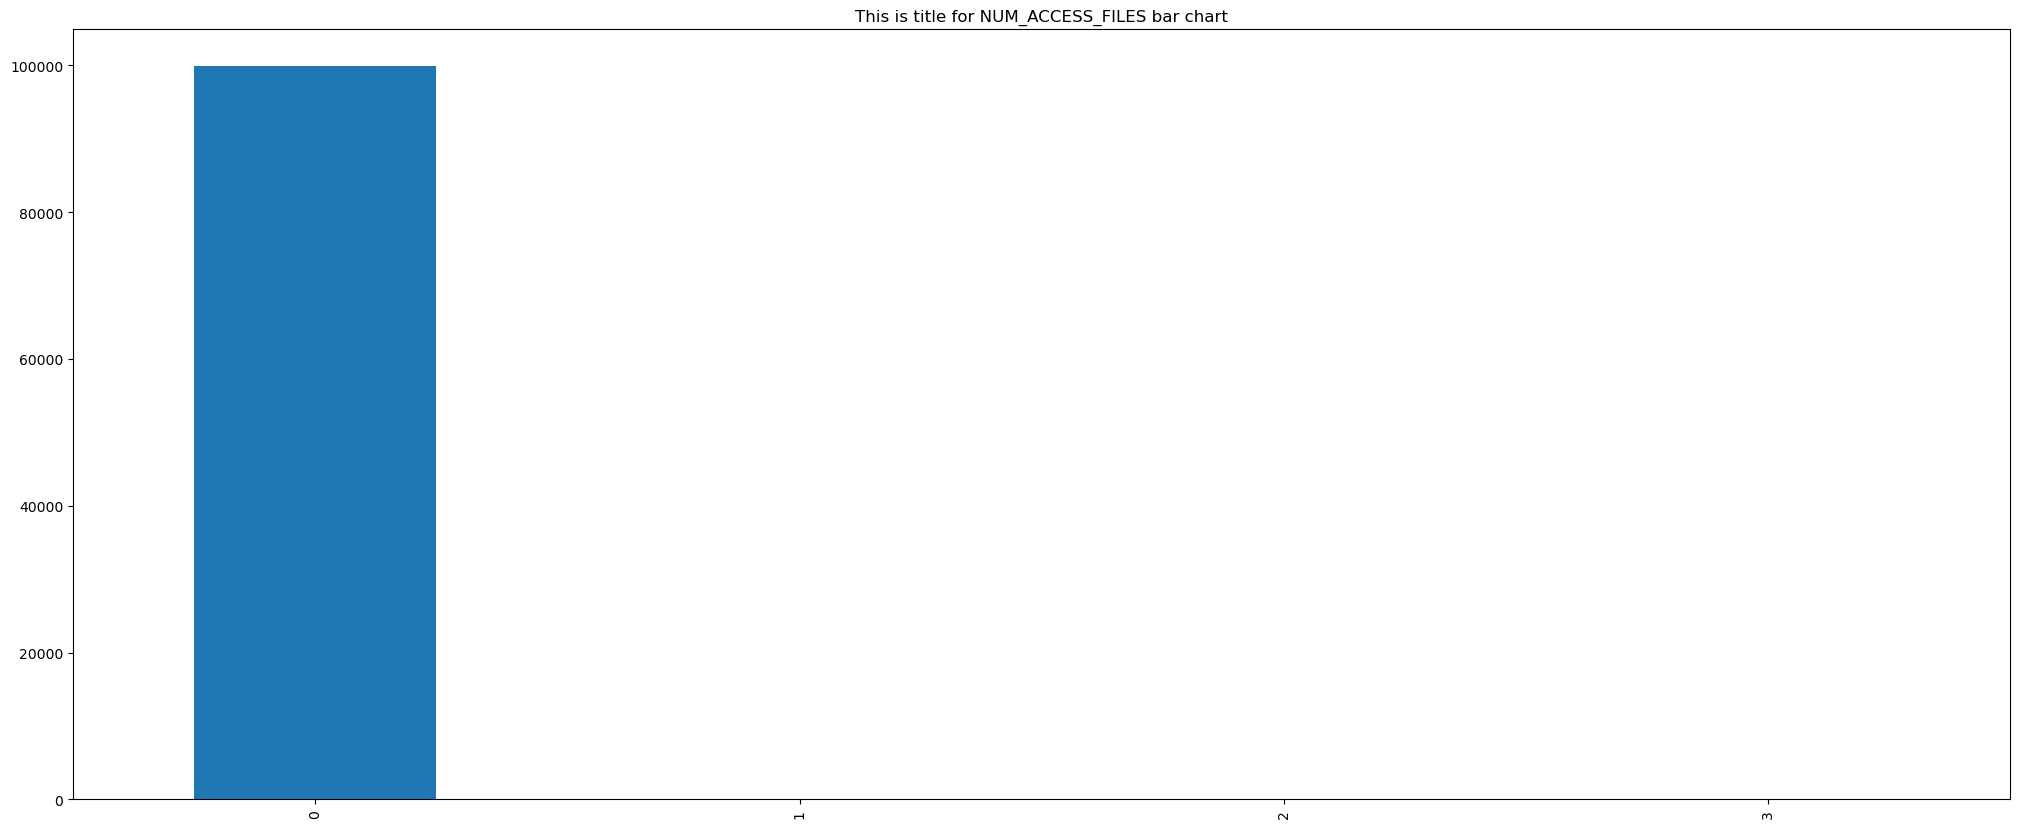

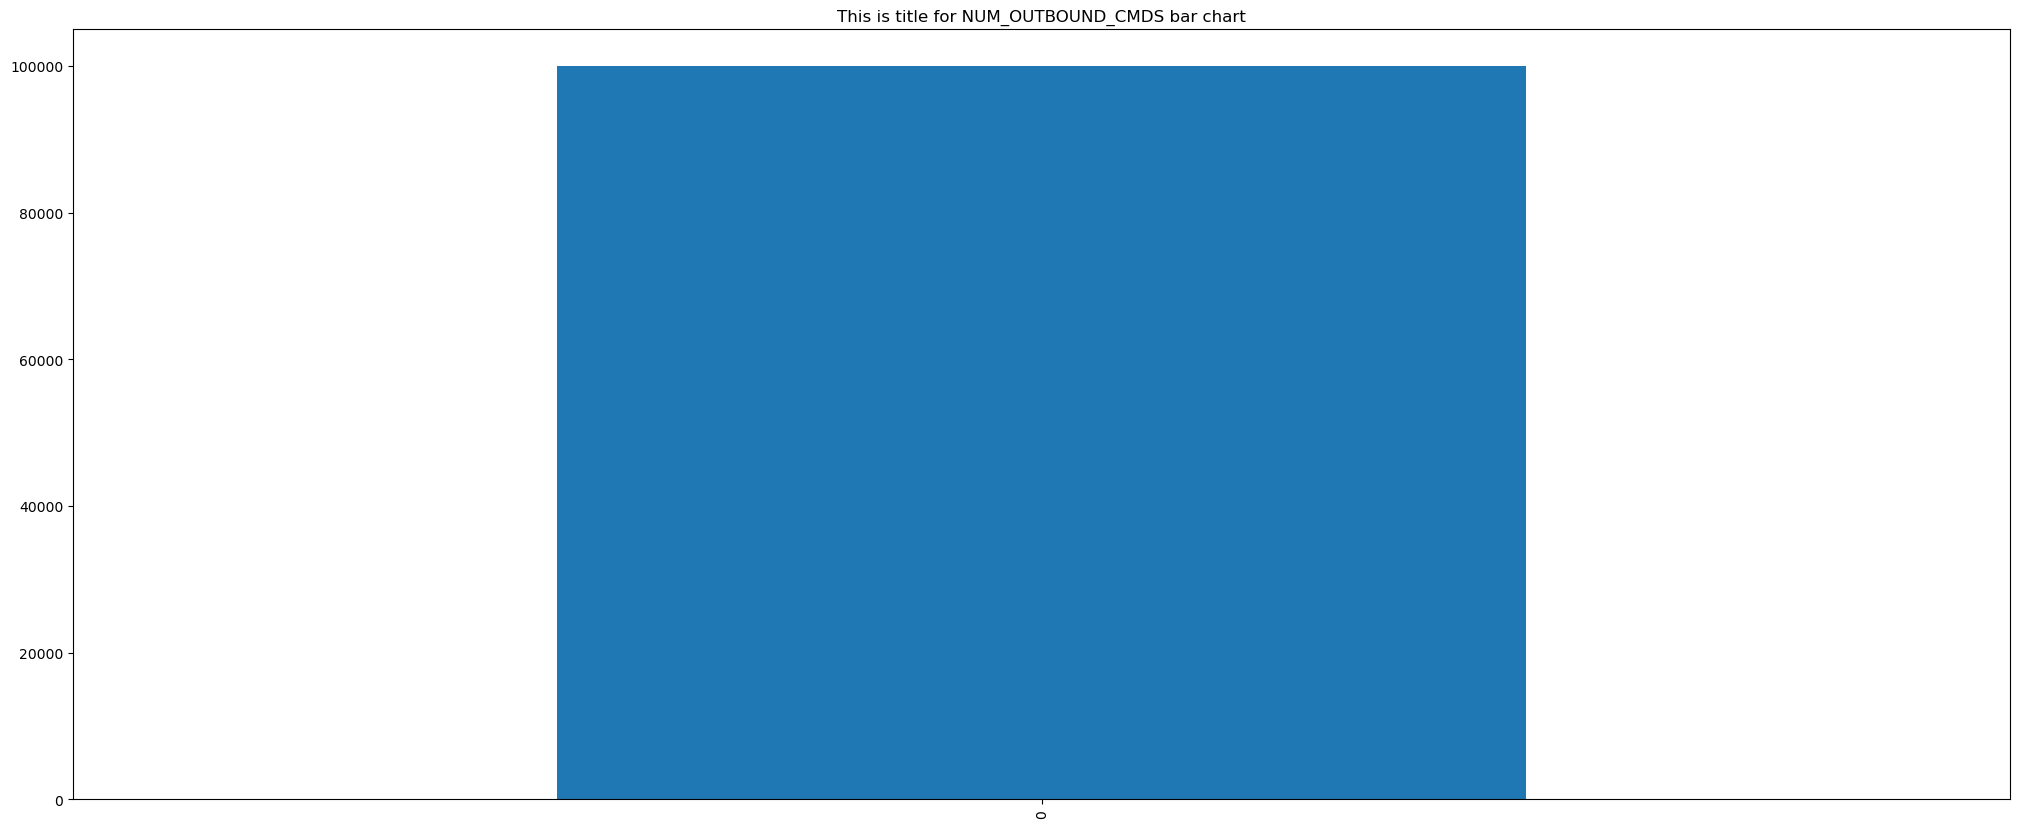

In [31]:
show_bar_plots_for_all_categorical_plots(eda_features_df, categorical_attributes)

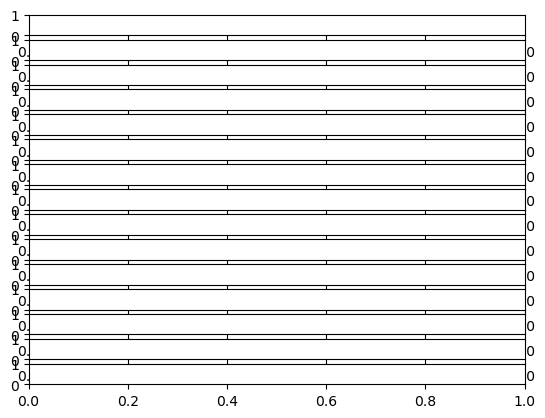

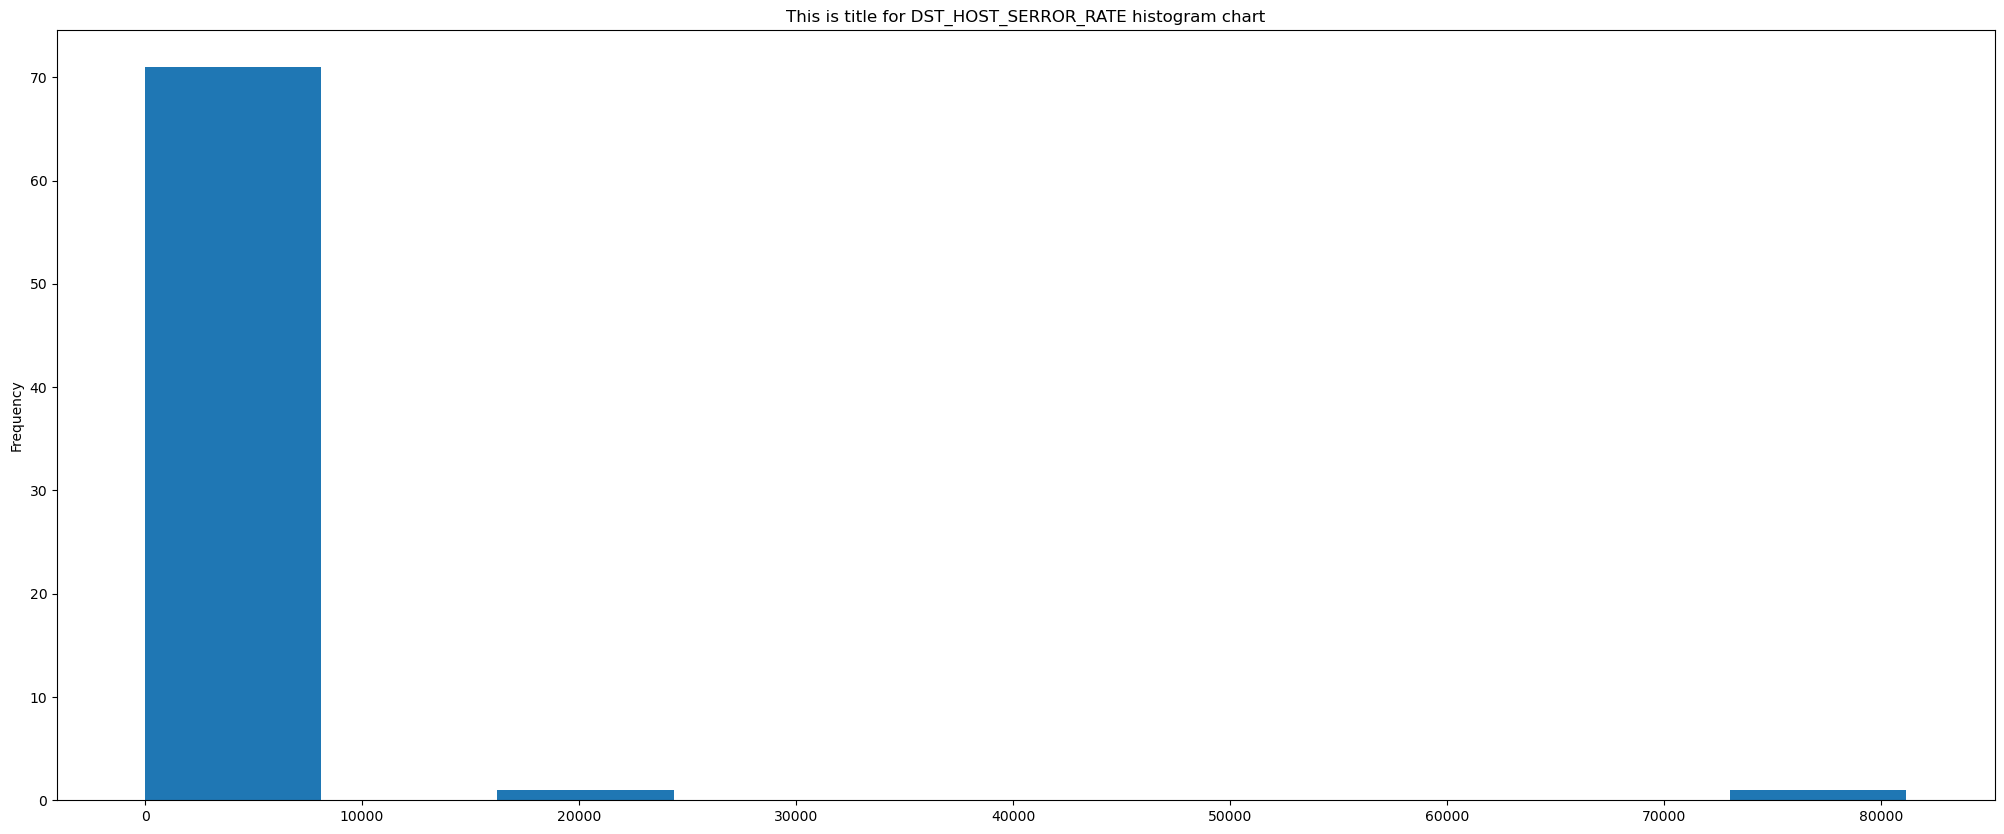

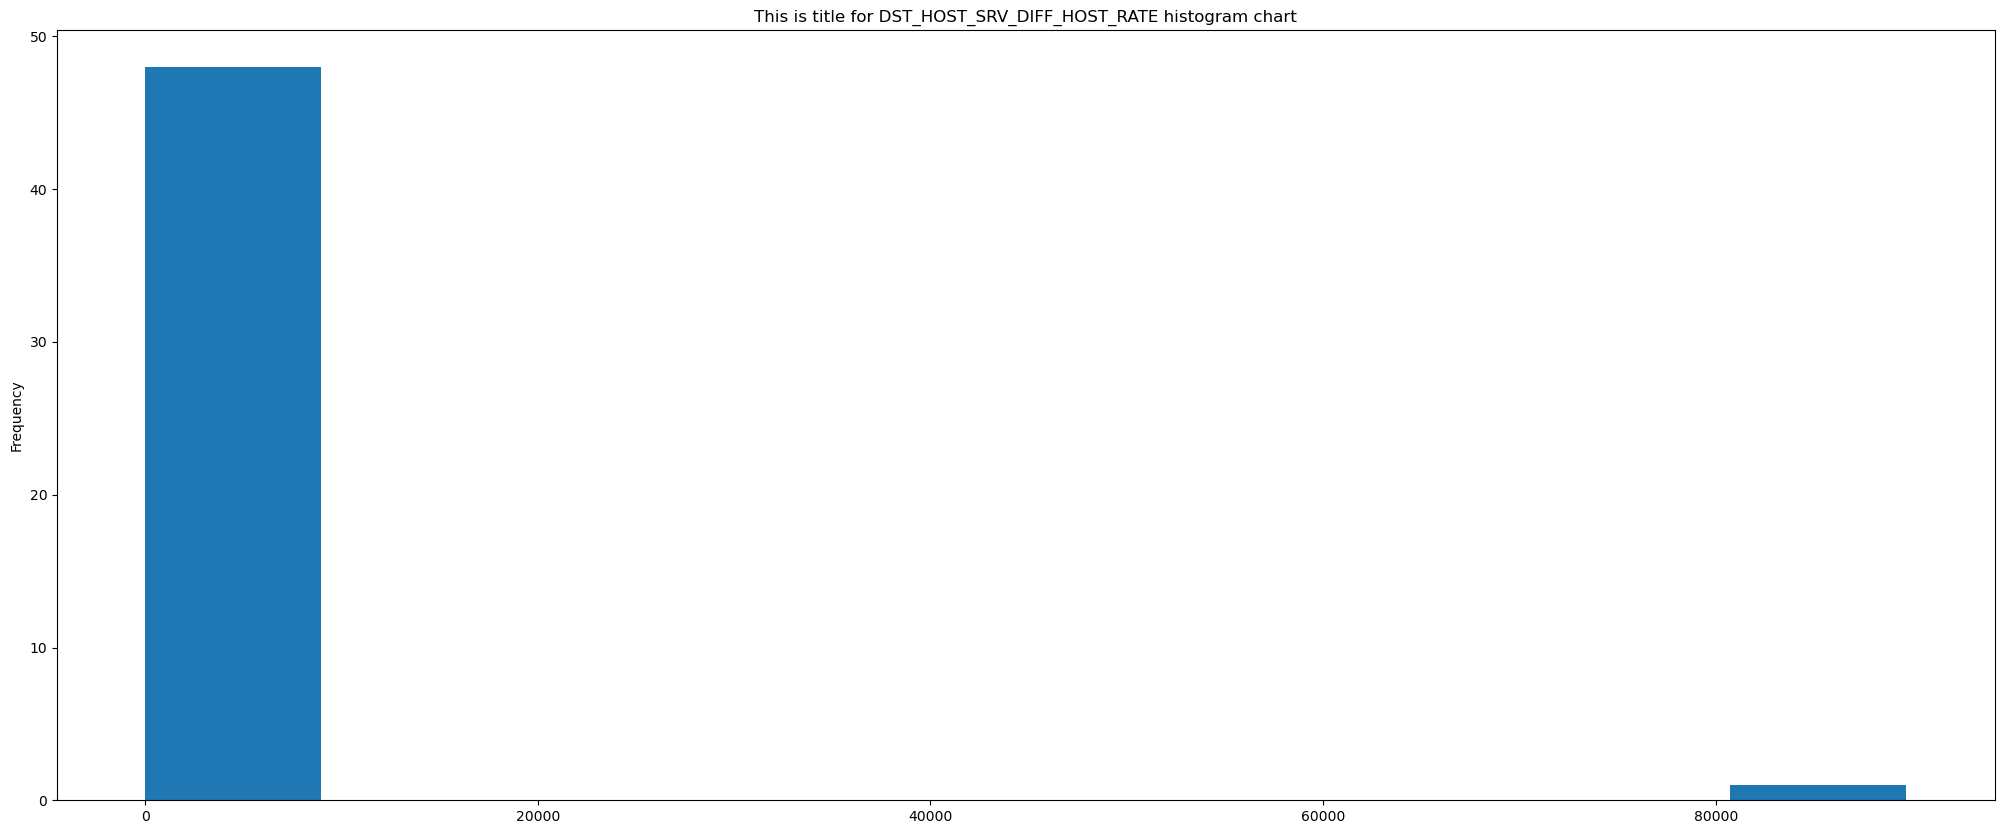

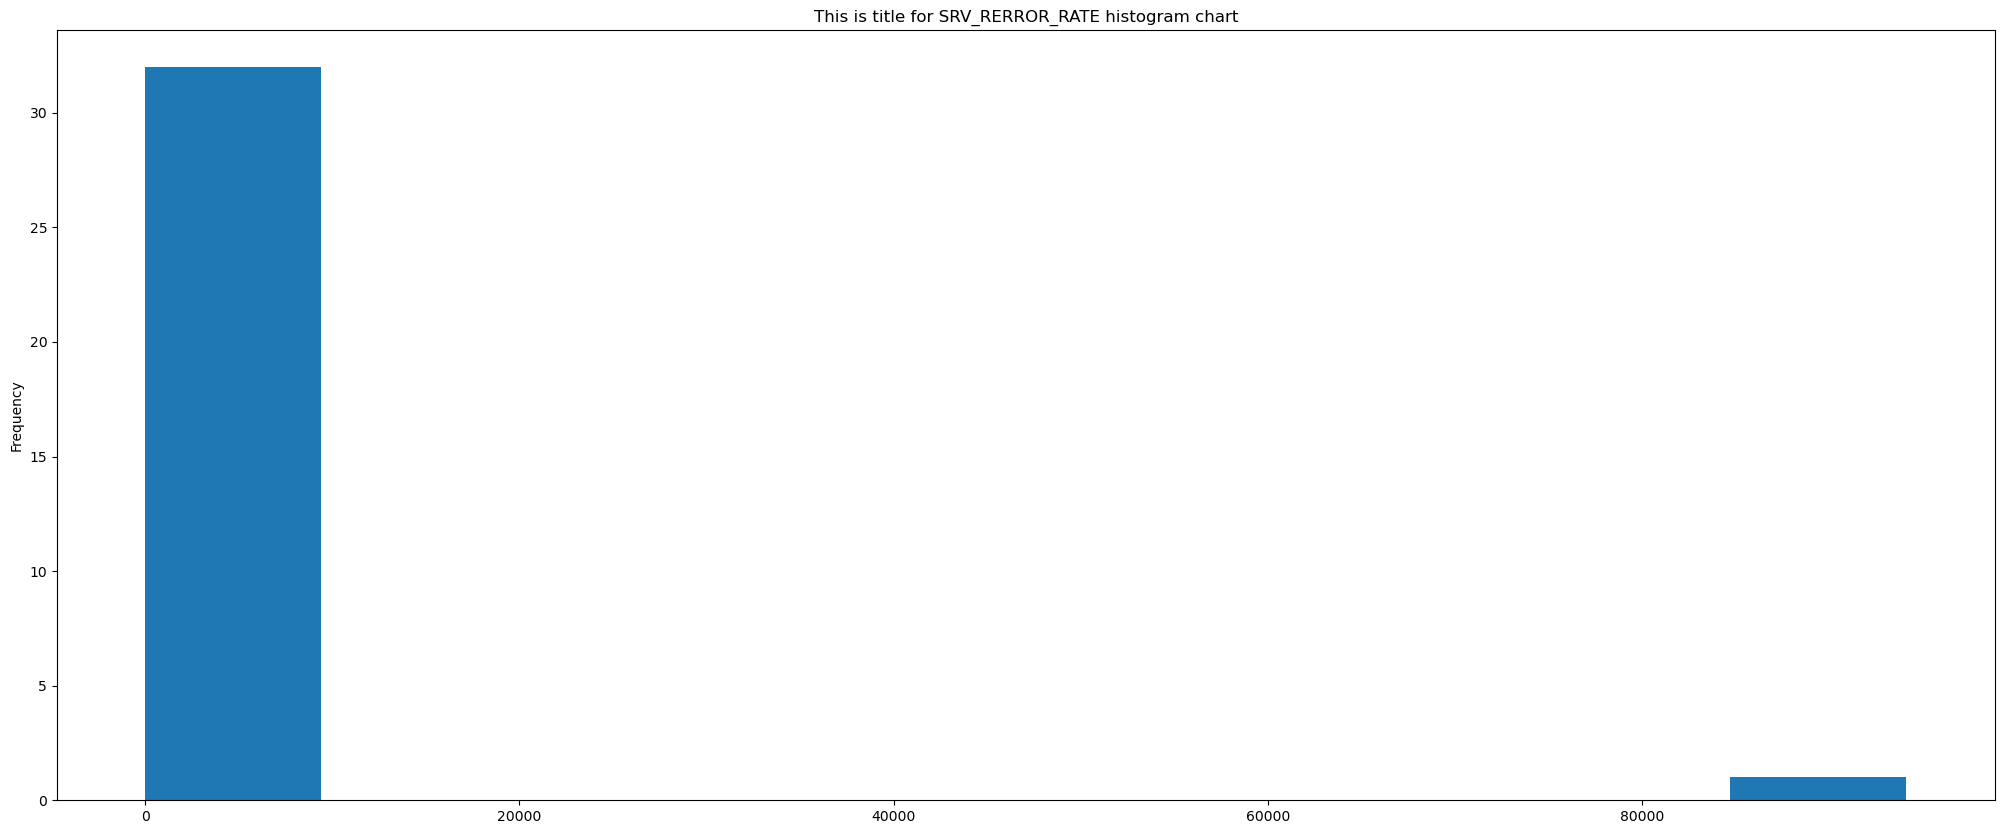

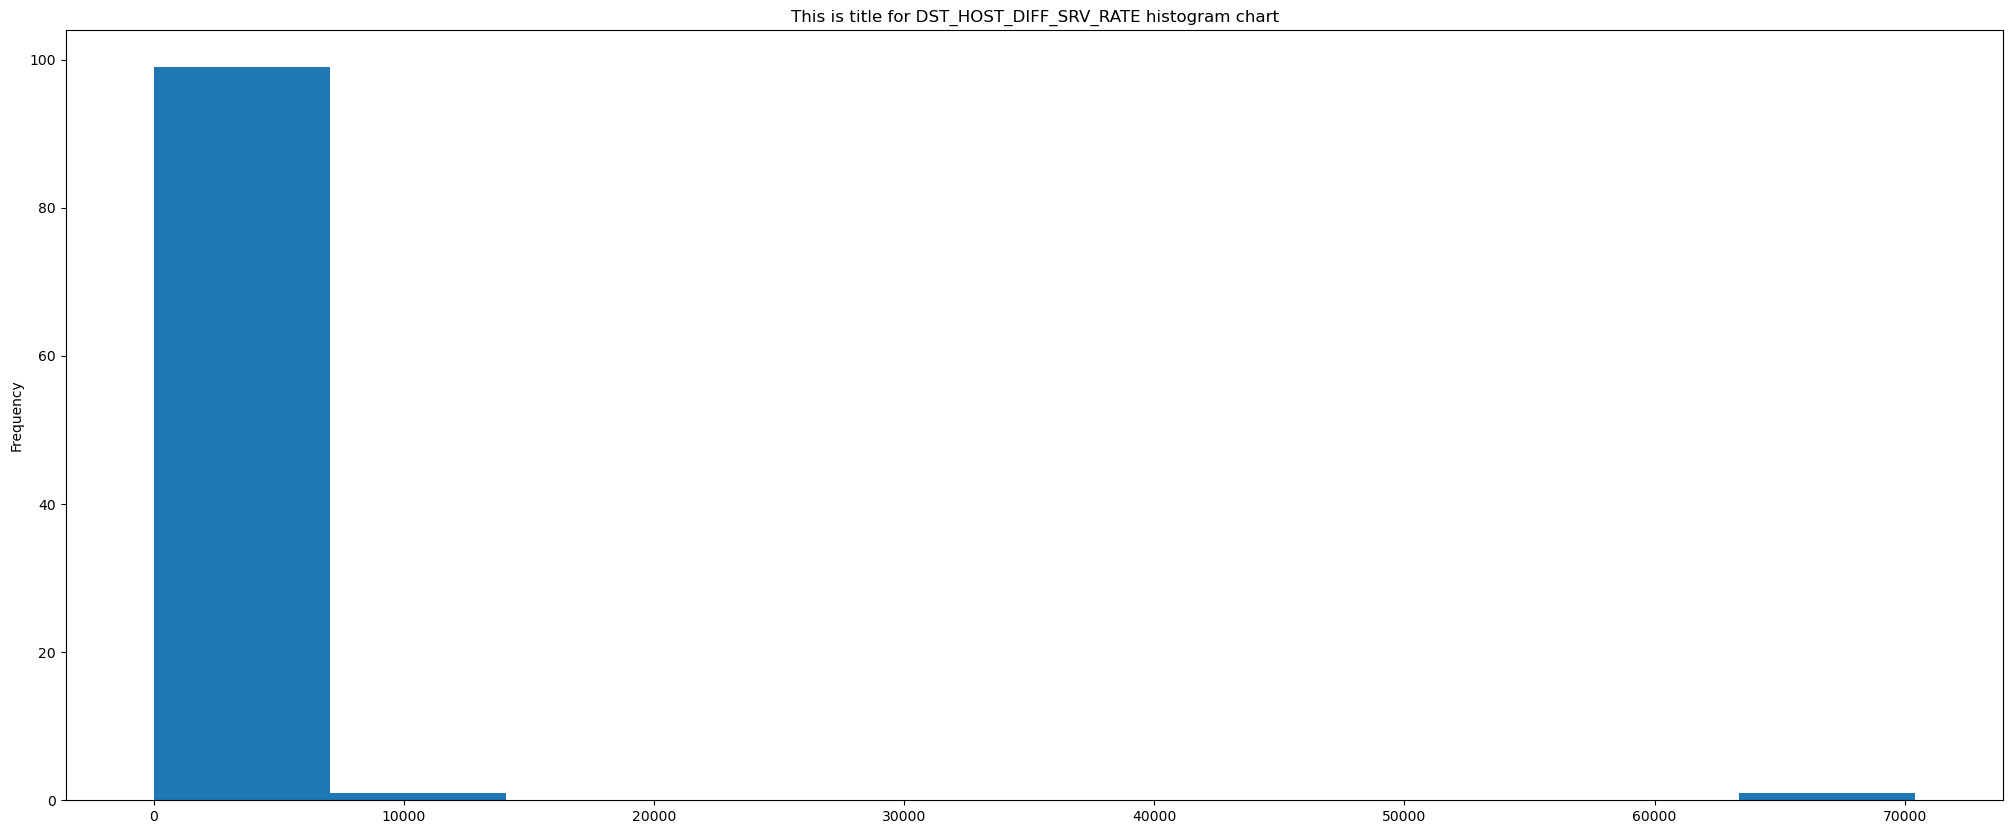

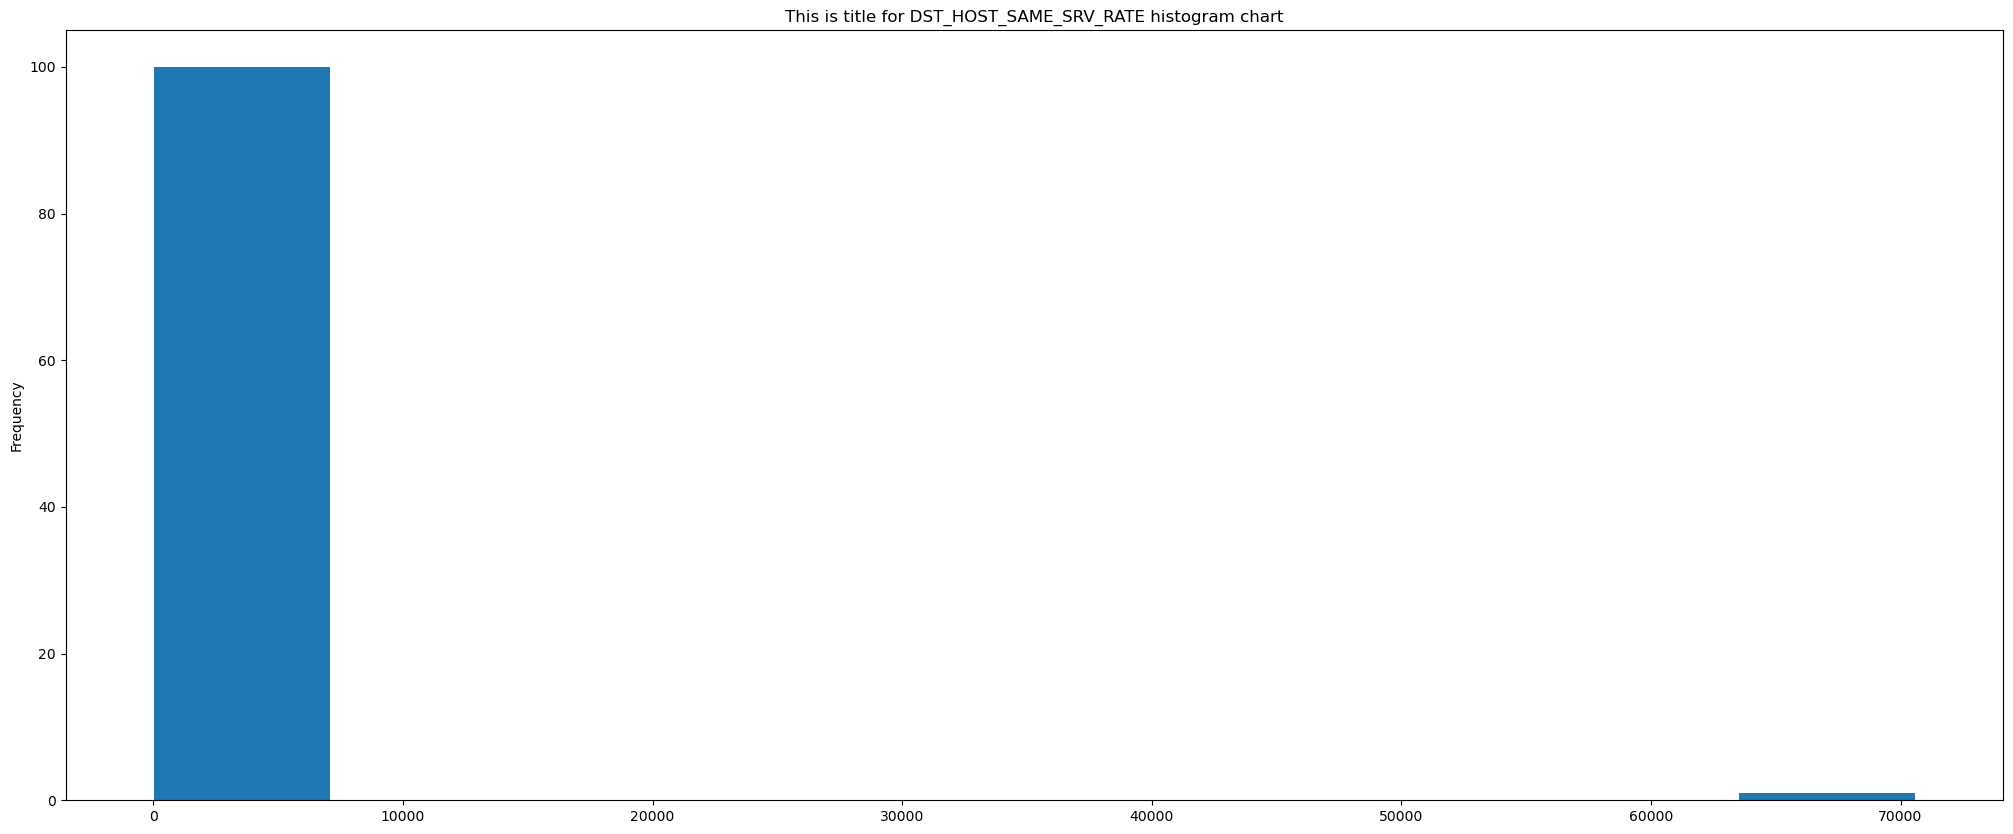

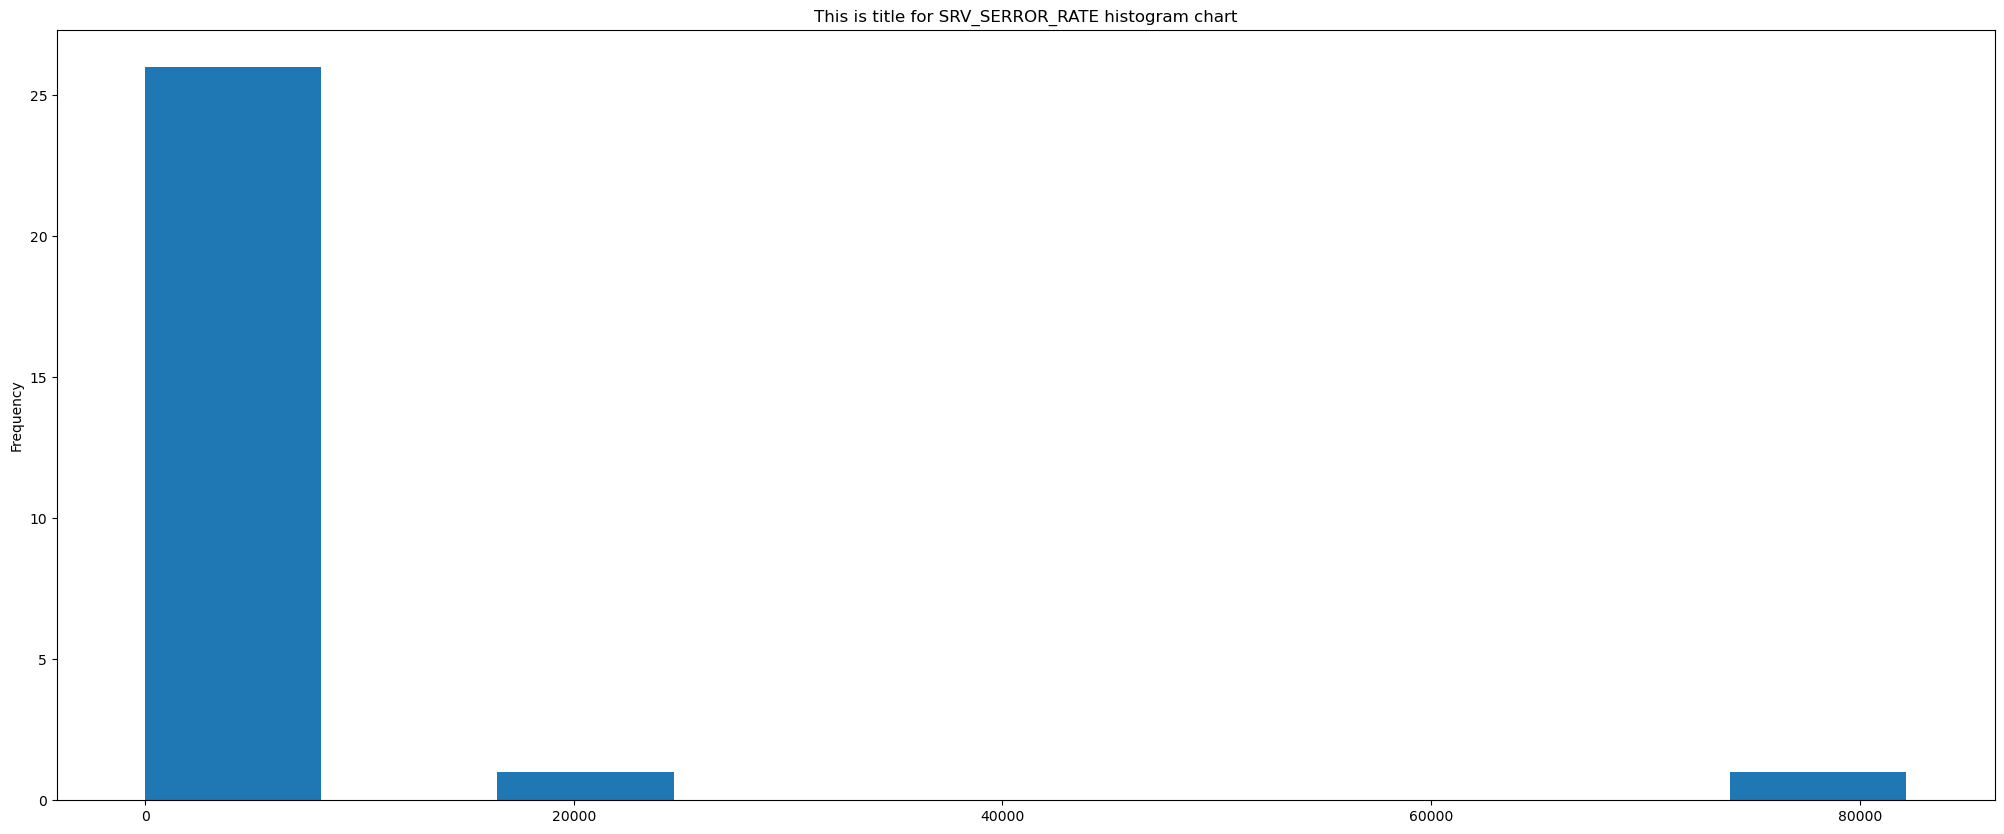

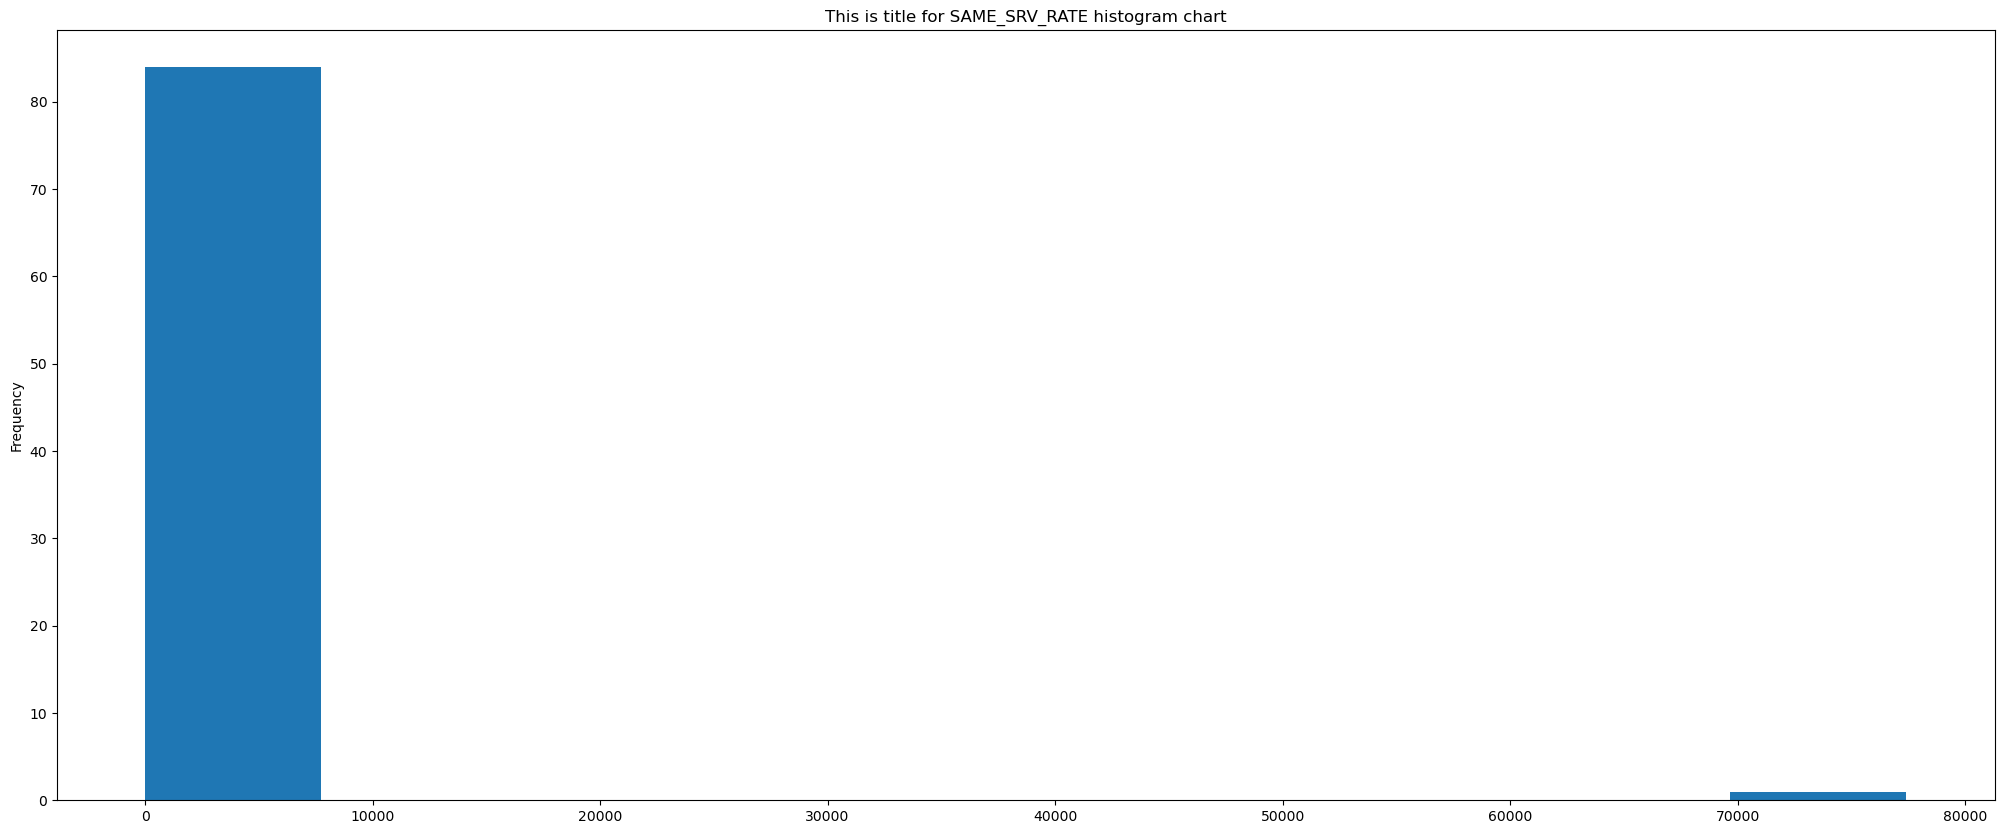

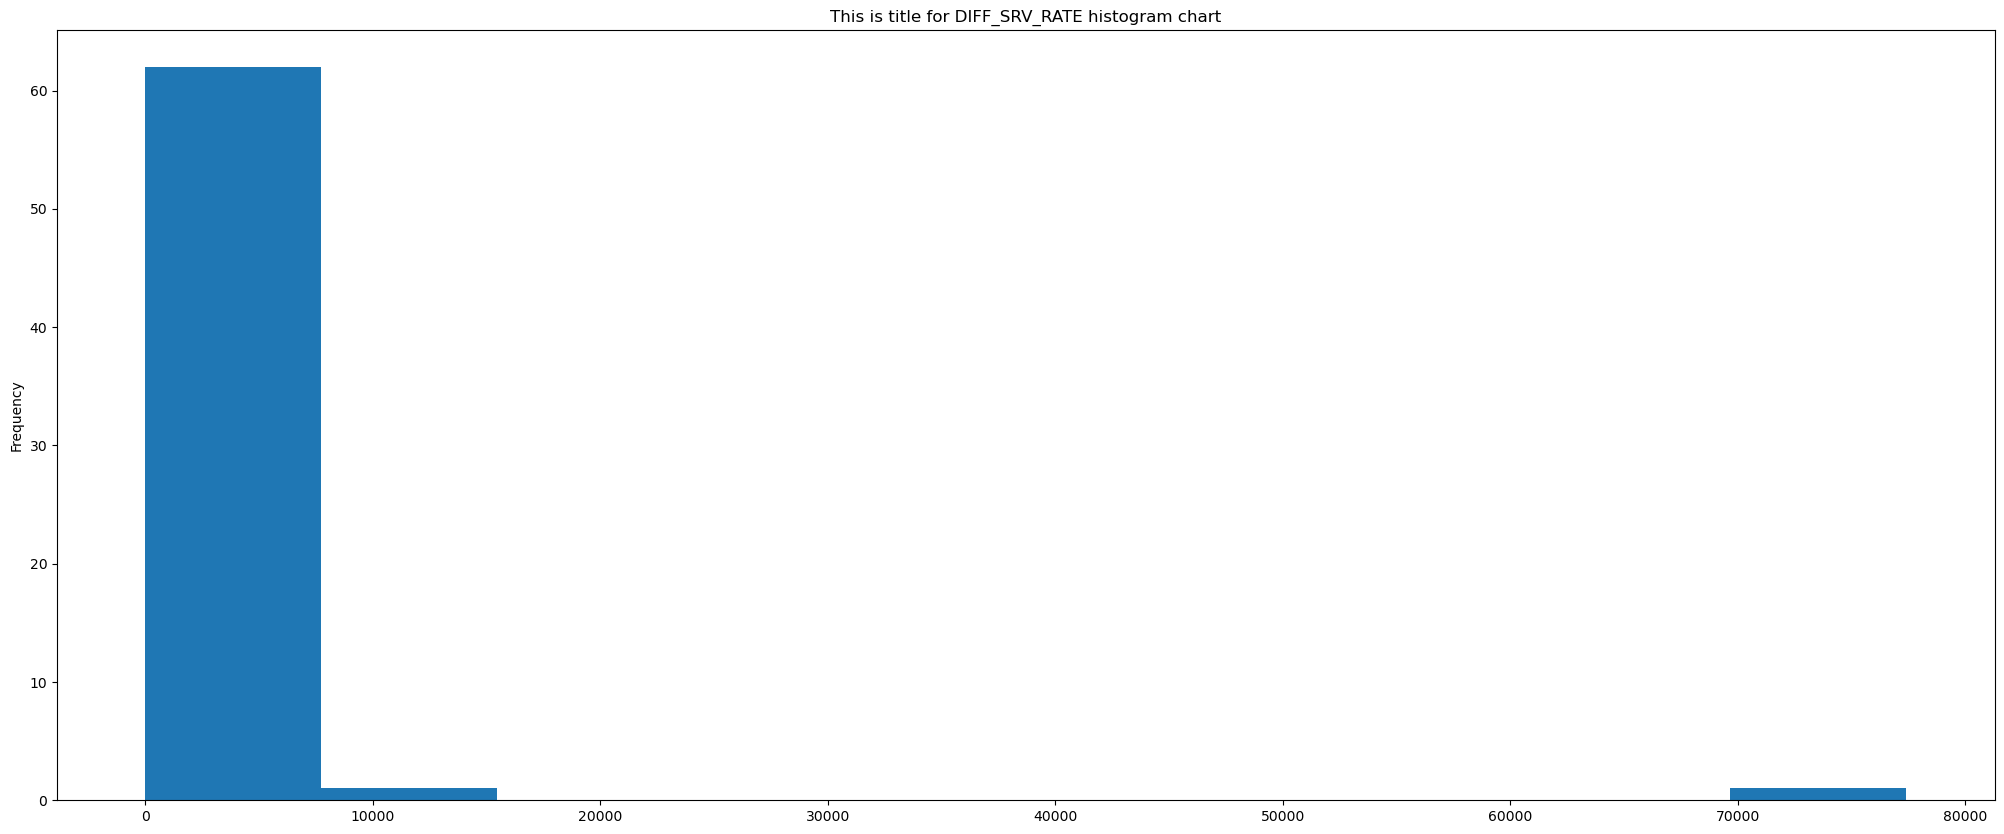

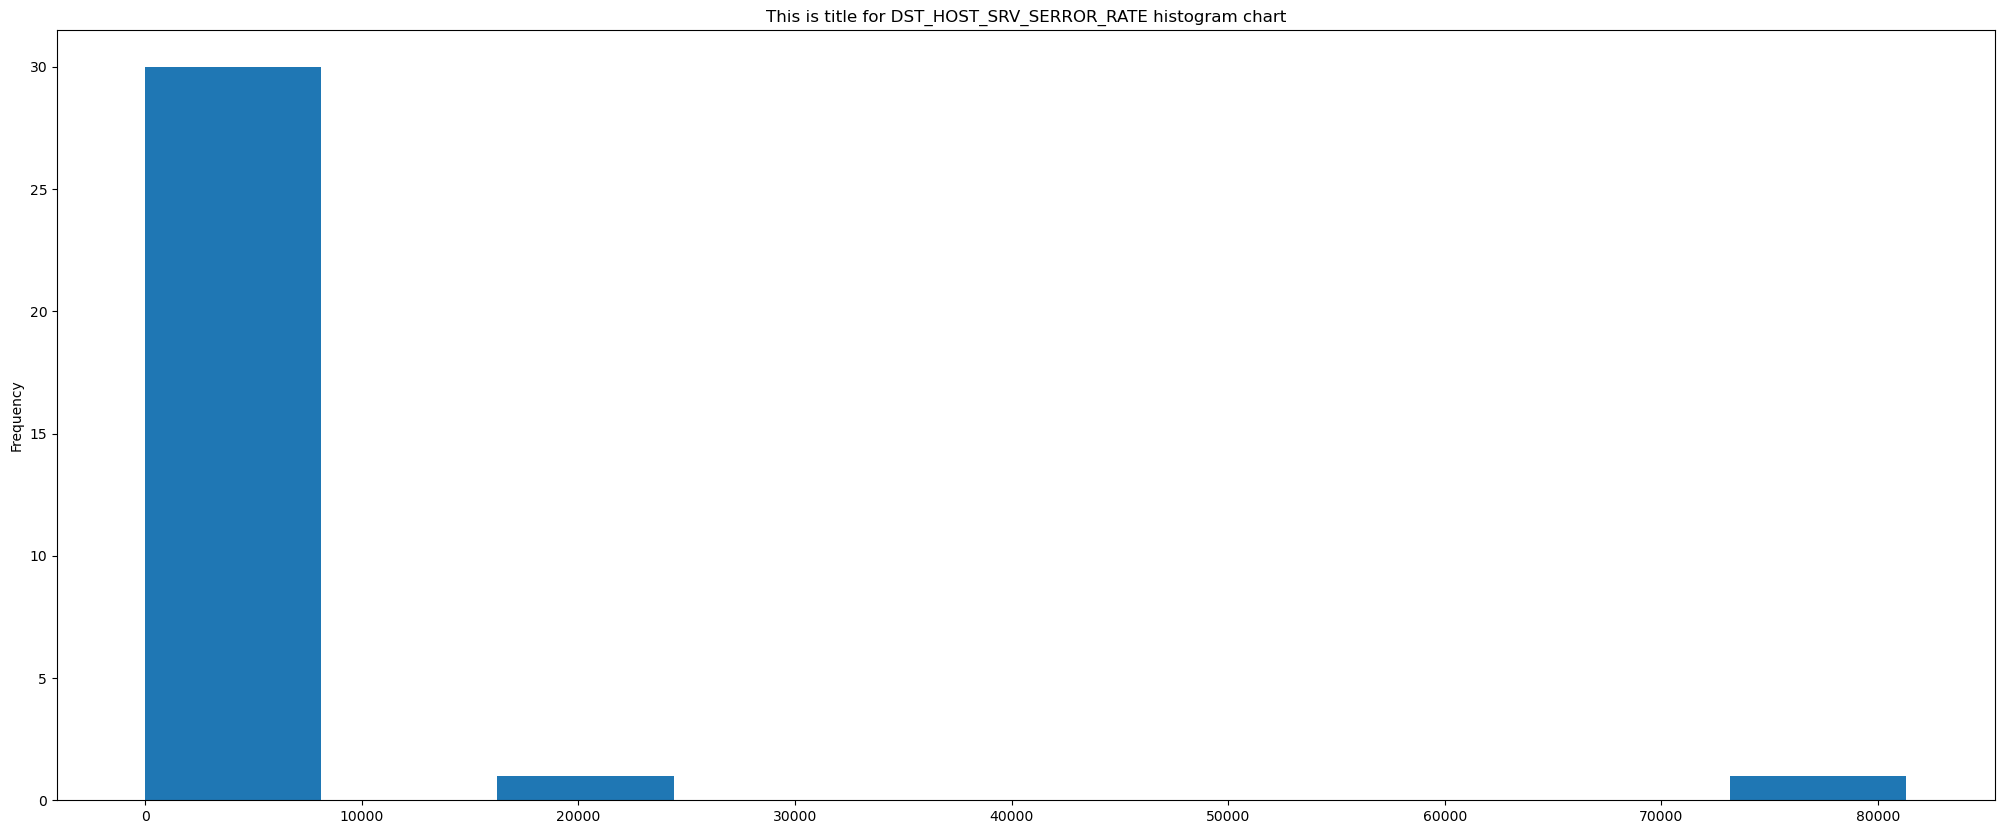

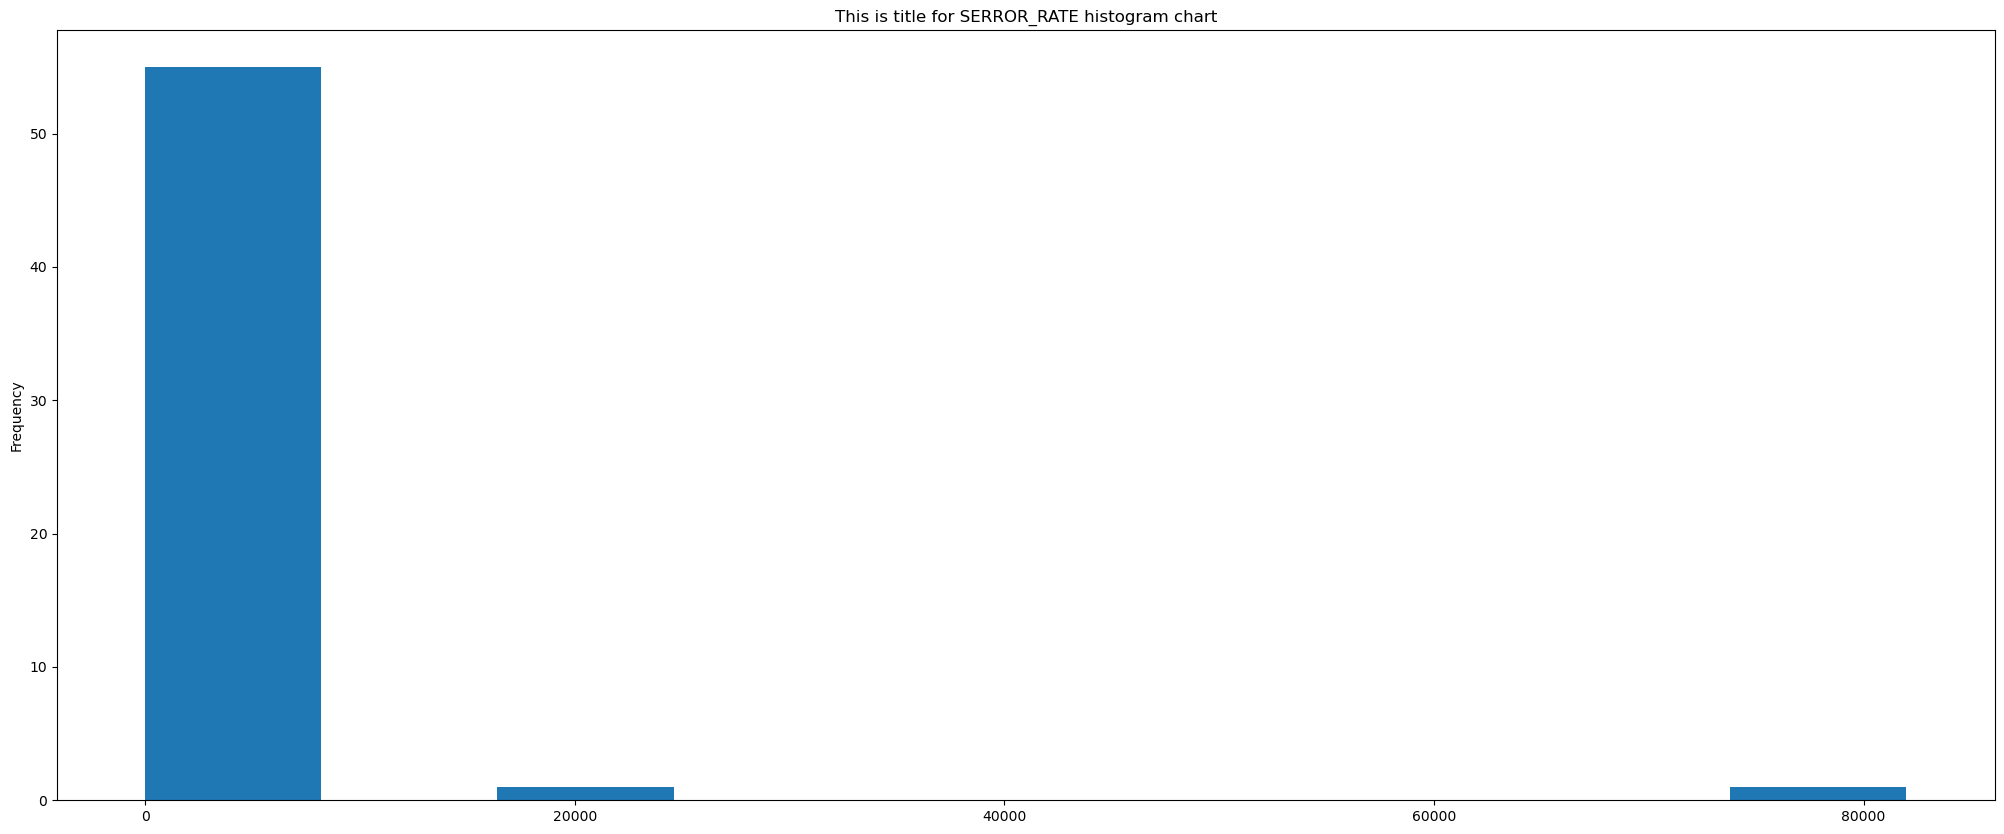

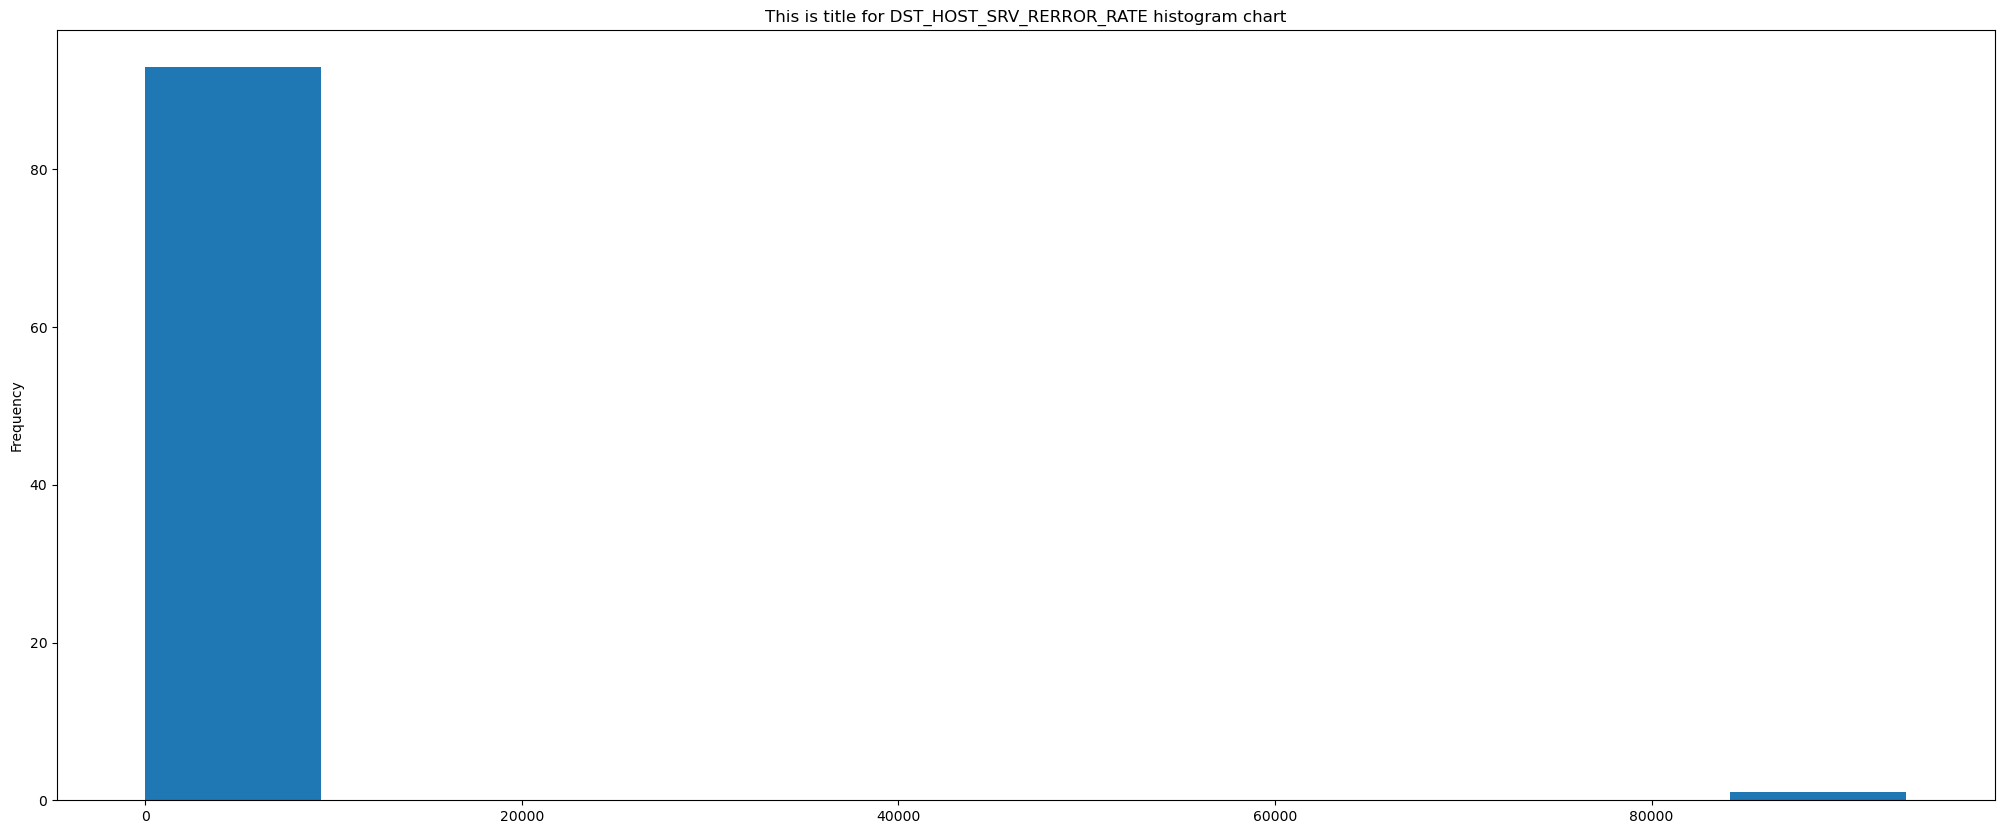

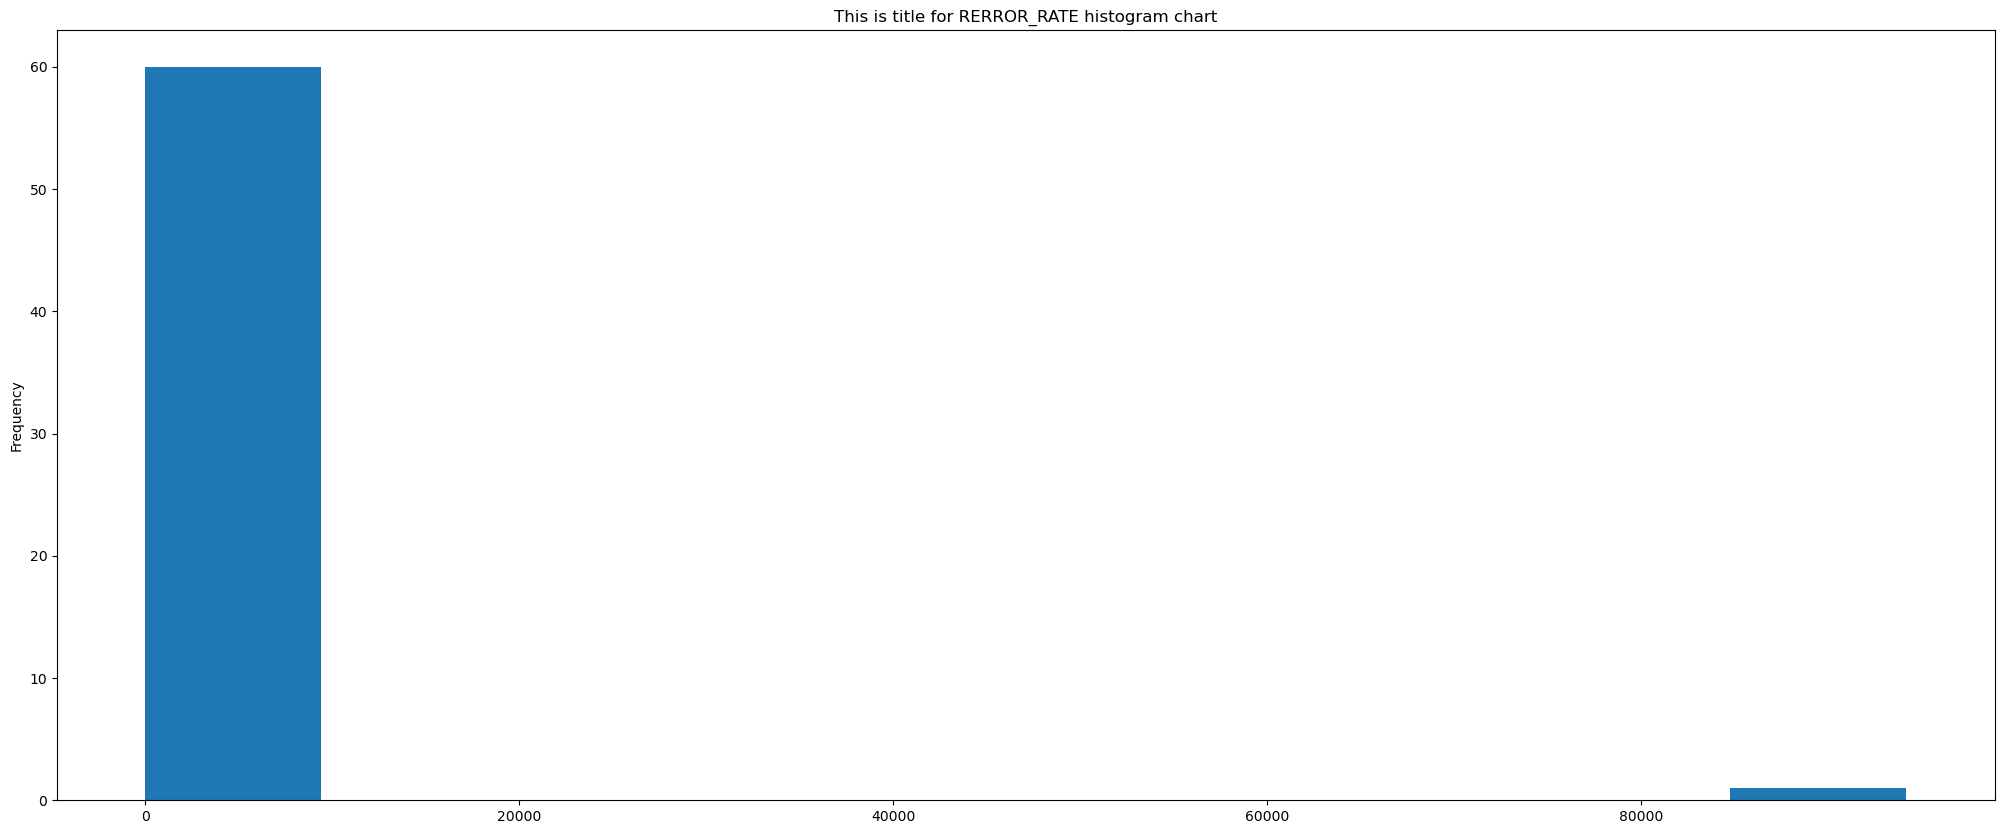

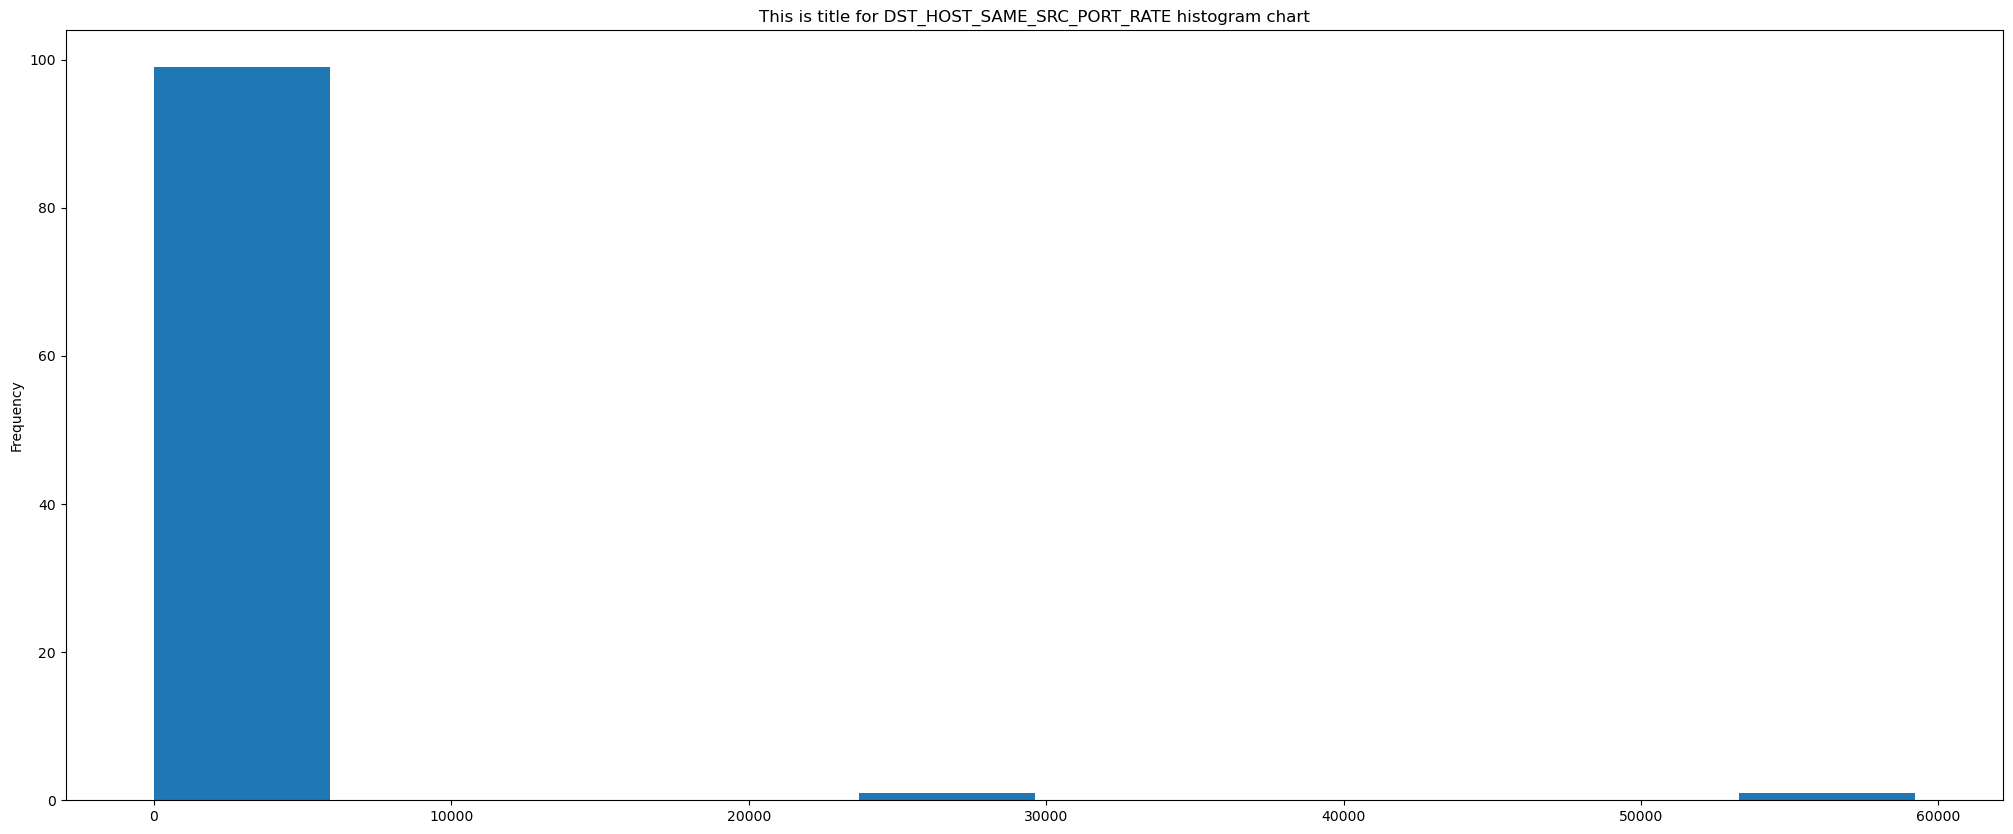

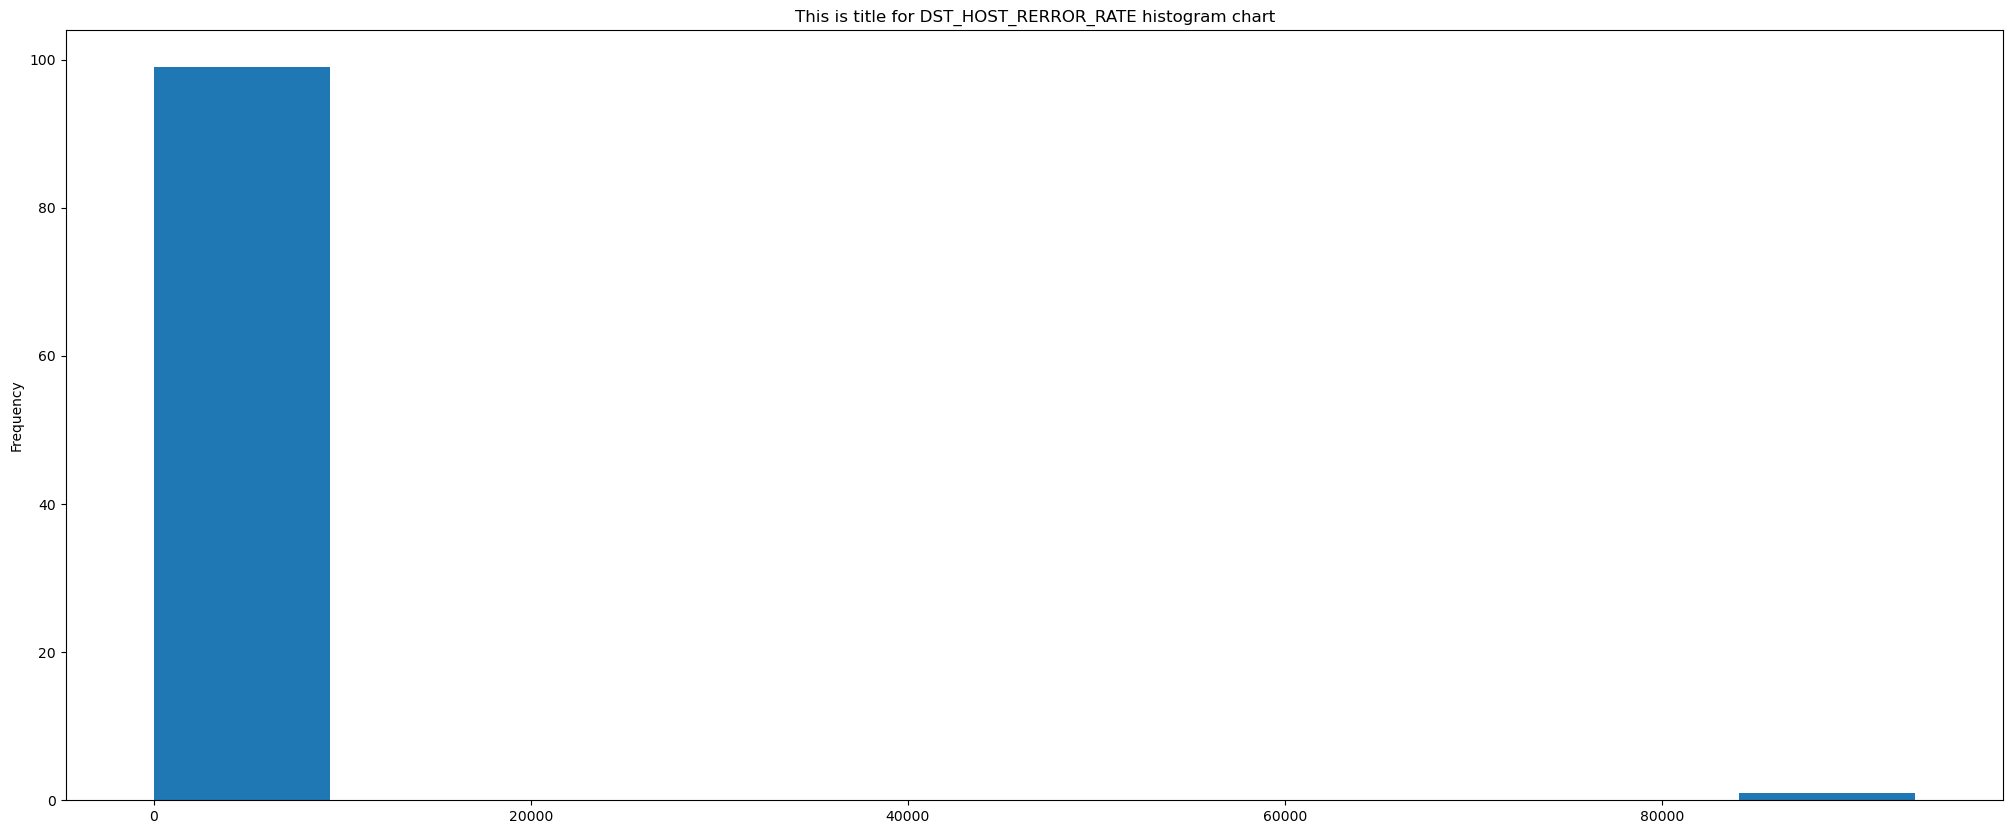

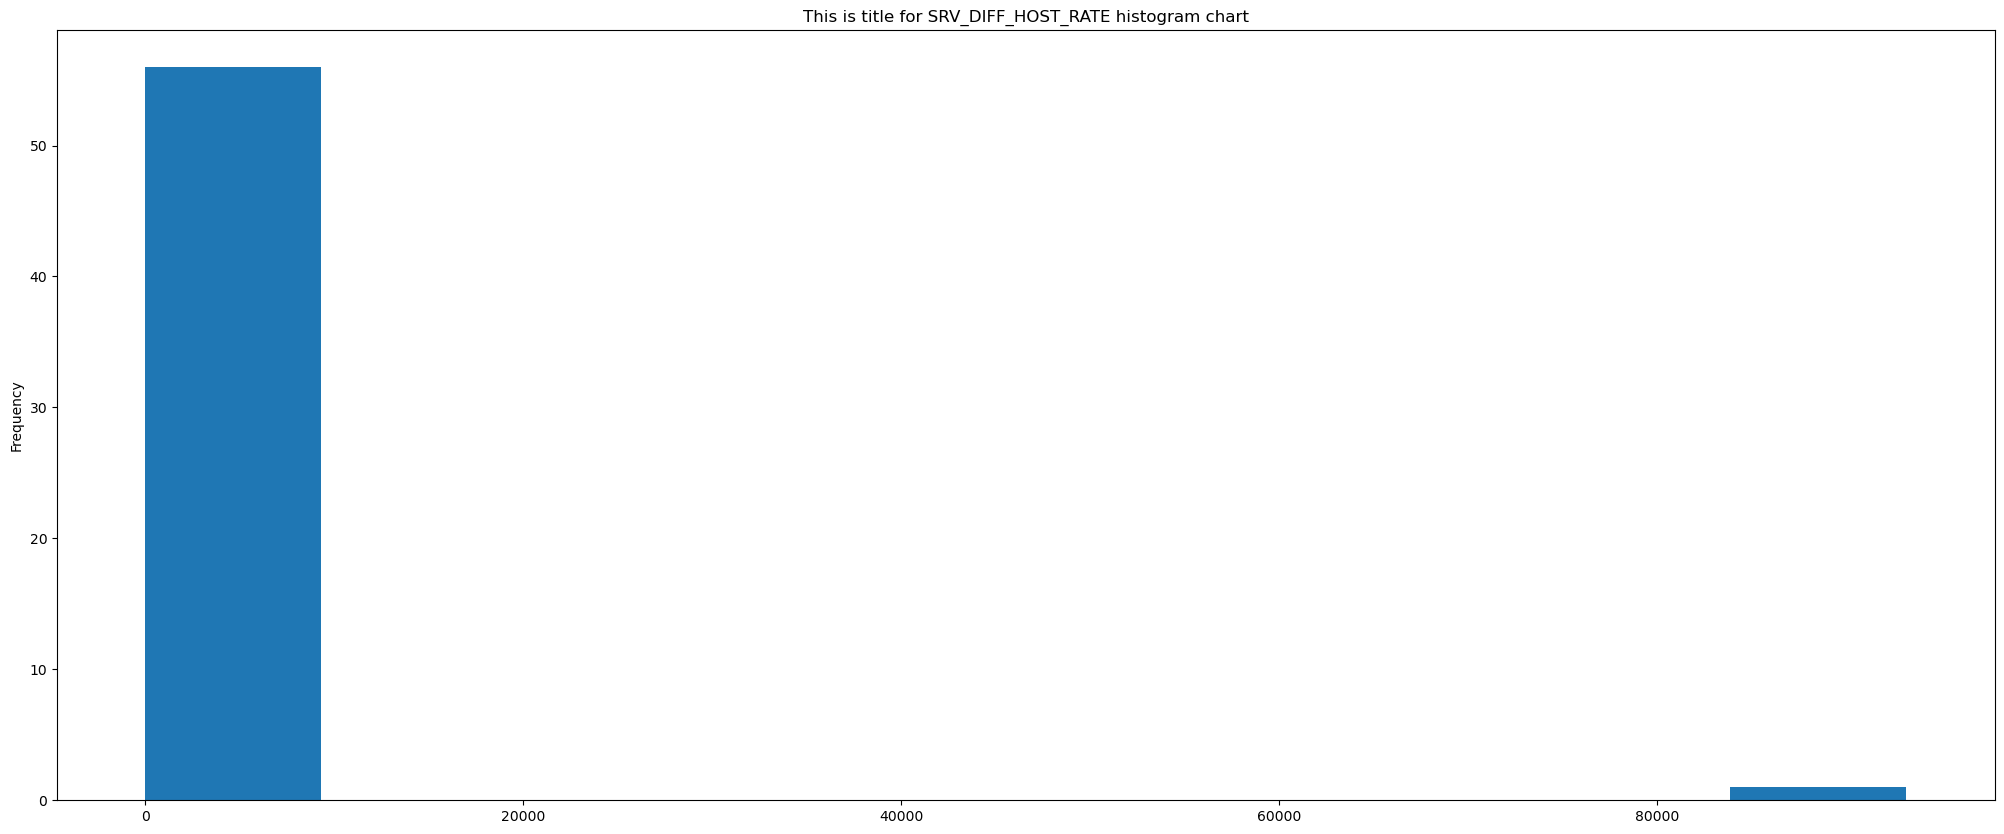

In [32]:
show_histogram_plots_for_all_continuous_plots(eda_features_df, continuous_attributes)

#### Spliting and Standardizing Dataset for Experiment I

In [33]:
target_kdd_cup_df = kdd_cup_df[target_variable]

In [34]:
features_kdd_cup_df = kdd_cup_df.drop([target_variable], axis=1)

In [35]:
features_kdd_cup_df = process_feature_mapping(features_kdd_cup_df)




FEATURE MAPPING FOR OBJECT DATA STRUCTURE IN DATAFRAME

Processing feature mapping for protocol_type feature


Processing feature mapping for service feature


Processing feature mapping for flag feature




In [36]:
X_train, X_test, y_train, y_test = train_test_split(features_kdd_cup_df, target_kdd_cup_df, test_size = 0.2, random_state = 0)

In [37]:
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [ ]:
ros = SMOTE()

X_train, y_train = ros.fit_resample(X_train, y_train)

In [ ]:
analysis_df_dict[x_train_key] = X_train
analysis_df_dict[x_test_key] = X_test
analysis_df_dict[y_train_key] = y_train
analysis_df_dict[y_test_key] = y_test

#### Experiment I

In [ ]:
experiment_type = "EXPERIMENT-ONE"

In [ ]:
perform_NaiveBayes_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
perform_SVM_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
perform_DecisionTree_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
perform_RFC_model_analysis(analysis_df_dict, analysis_results, experiment_type)

In [ ]:
perform_ANN_model_analysis(analysis_df_dict, analysis_results, experiment_type)